<a href="https://colab.research.google.com/github/Ayesha-Feroz/Python-script-for-Mass-decoy/blob/main/FDR_estimation_code_of_paper24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

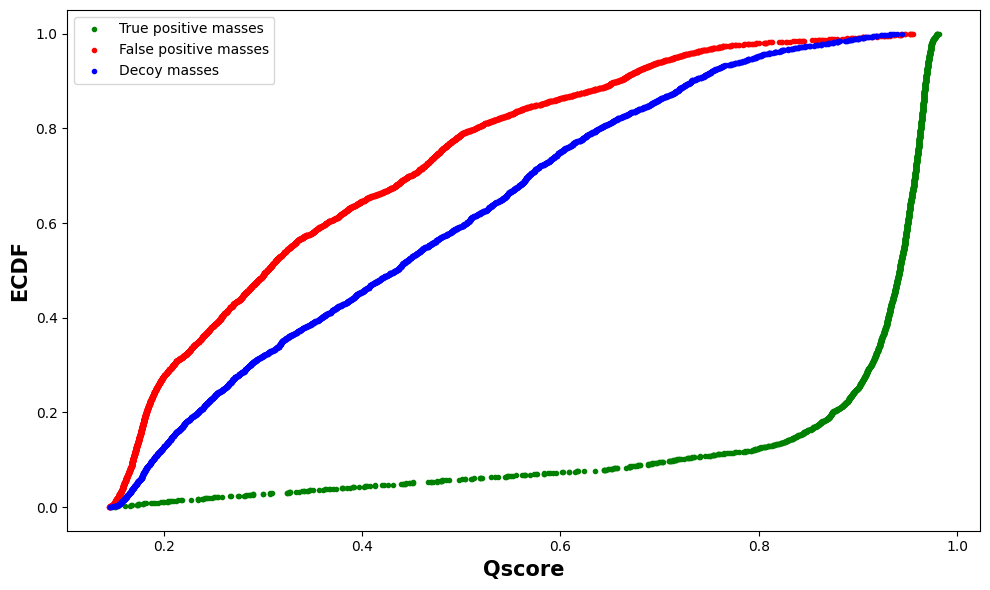

<ipython-input-8-d79cc5187d0a>:78: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=true_positives_df['Qscore'], shade=True, color='green')
<ipython-input-8-d79cc5187d0a>:79: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=false_positives_df['Qscore'], shade=True, color='red')
<ipython-input-8-d79cc5187d0a>:80: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=dummy_masses_df['Qscore'], shade=True, color='blue')


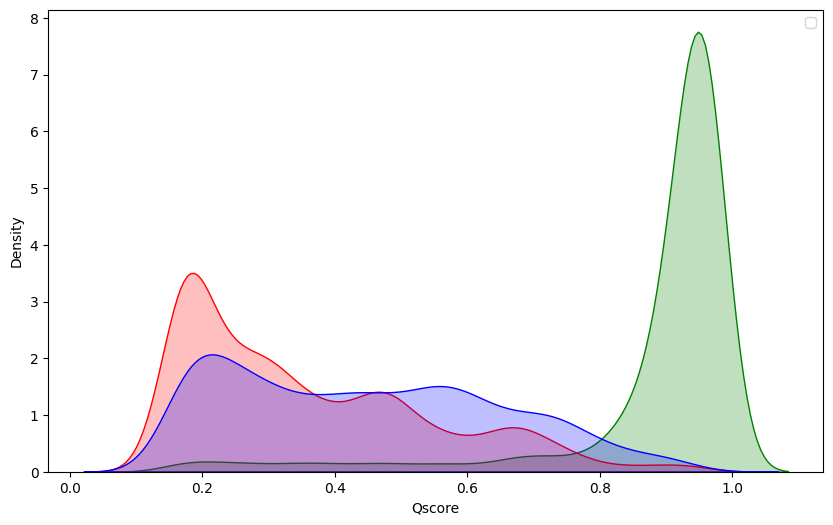

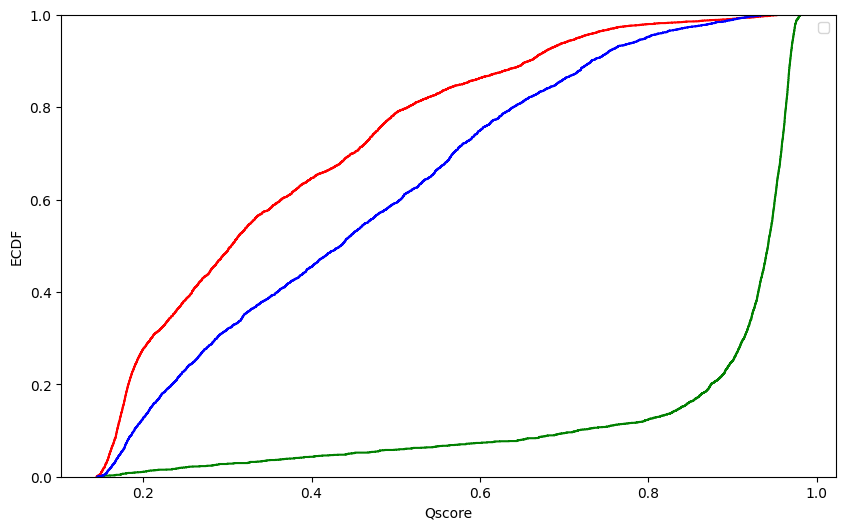

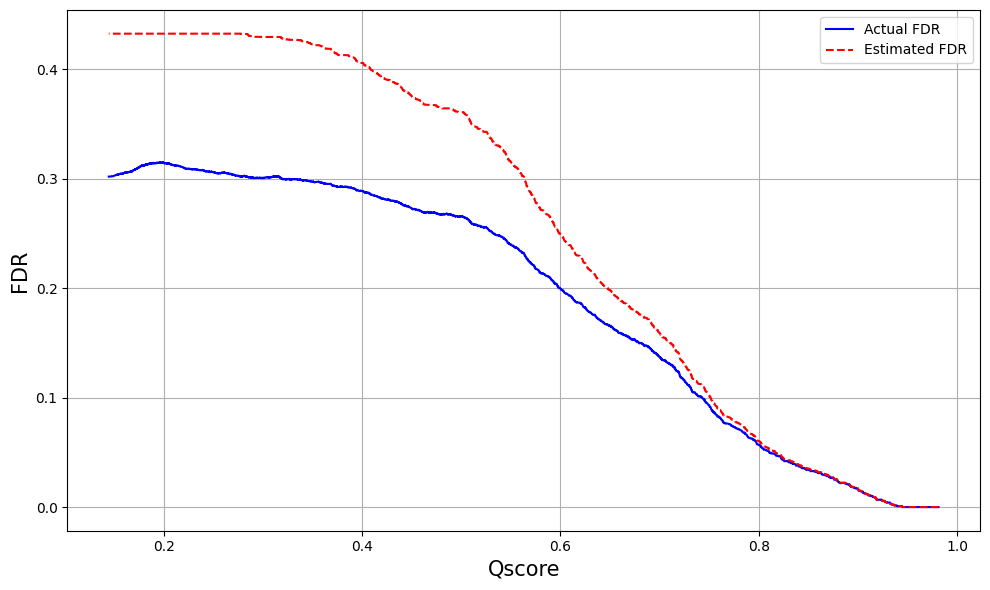

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load the deconvolved CSV file
deconvolved_df = pd.read_csv('/content/adder_res35k_1e3.tsv', sep= '\t')  # Replace with the path to your deconvolved CSV file

# Load the true masses CSV file
true_masses_df = pd.read_csv('/content/chosen.csv')  # Replace with the path to your true masses CSV file

# Define ppm tolerance
ppm_tolerance = 10  # Adjust as needed

# Filter deconvolved_df for rows where TargetDummyType is 0
filtered_deconvolved_df = deconvolved_df[deconvolved_df['TargetDecoyType'] == 0]

# Initialize empty lists for true positives, false positives, and dummy masses
true_positives = []
false_positives = []
dummy_masses = []

# Iterate through rows in filtered_deconvolved_df
for index, row in filtered_deconvolved_df.iterrows():
    # Calculate ppm difference between each MonoisotopicMass in filtered_deconvolved_df
    # and true_masses_df and check if it's within ppm_tolerance or ±1 isotope error with 0.1 Da tolerance
    ppm_diff = abs(row['MonoisotopicMass'] - true_masses_df['MonoisotopicMass']) / true_masses_df['MonoisotopicMass'] * 1e6
    isotope_error_condition = (
        (ppm_diff <= ppm_tolerance) |
        ((row['MonoisotopicMass'] >= true_masses_df['MonoisotopicMass'] - 0.1) &
         (row['MonoisotopicMass'] <= true_masses_df['MonoisotopicMass'] + 0.1)) |
        ((row['MonoisotopicMass'] >= true_masses_df['MonoisotopicMass'] - 1.1) &
         (row['MonoisotopicMass'] <= true_masses_df['MonoisotopicMass'] - 0.9)) |
        ((row['MonoisotopicMass'] >= true_masses_df['MonoisotopicMass'] + 0.9) &
         (row['MonoisotopicMass'] <= true_masses_df['MonoisotopicMass'] + 1.1))
    )
    matches_within_tolerance = any(isotope_error_condition)

    # Classify the rows based on matching criteria
    if matches_within_tolerance:
        true_positives.append(row)
    else:
        false_positives.append(row)


# Filter the deconvolved_df for rows where TargetDummyType is greater than 0
dummy_masses_df = deconvolved_df[deconvolved_df['TargetDecoyType'] > 0]

# Convert true_positives and false_positives to dataframes
true_positives_df = pd.DataFrame(true_positives)
false_positives_df = pd.DataFrame(false_positives)

# Create ECDF plots based on Qscore
plt.figure(figsize=(10, 6))

# Function to calculate ECDF
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y

# Create ECDF plots for True Positives, False Positives, and Dummy Masses
for data, label, color in [(true_positives_df['Qscore'], 'True positive masses', 'green'),
                           (false_positives_df['Qscore'], 'False positive masses', 'red'),
                           (dummy_masses_df['Qscore'], 'Decoy masses', 'blue')]:
    x, y = ecdf(data)
    plt.plot(x, y, marker='.', linestyle='none', label=label, color=color)

plt.xlabel('Qscore', fontsize=15, fontweight='bold')
plt.ylabel('ECDF', fontsize=15, fontweight='bold')
#plt.title('ECDF Plot for Resolution=70k, Noise=1e3, b, y', fontsize=15, fontweight='bold')
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=true_positives_df['Qscore'], shade=True, color='green')
sns.kdeplot(data=false_positives_df['Qscore'], shade=True, color='red')
sns.kdeplot(data=dummy_masses_df['Qscore'], shade=True, color='blue')
plt.xlabel('Qscore')
plt.ylabel('Density')
#plt.title('Res240k,noise 1e5,b,y')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.ecdfplot(data=true_positives_df['Qscore'], color='green')
sns.ecdfplot(data=false_positives_df['Qscore'], color='red')
sns.ecdfplot(data=dummy_masses_df['Qscore'], color='blue')
plt.xlabel('Qscore')
plt.ylabel('ECDF')
#plt.title('Empirical Cumulative Distribution Function,res=240k,noise=1e5,b,y')
plt.legend()
plt.show()

# Calculate the cumulative number of targets and decoys
deconvolved_df_sorted = deconvolved_df.sort_values('Qscore', ascending=False)
deconvolved_df_sorted['cumulative_targets'] = np.cumsum(deconvolved_df_sorted['TargetDecoyType'] == 0)
deconvolved_df_sorted['cumulative_decoys'] = np.cumsum(deconvolved_df_sorted['TargetDecoyType'] > 0)

# Calculate FDR and q-values
deconvolved_df_sorted['FDR'] = deconvolved_df_sorted['cumulative_decoys'] / deconvolved_df_sorted['cumulative_targets']
deconvolved_df_sorted['q_value'] = deconvolved_df_sorted['FDR'][::-1].cummin()[::-1]



# Calculate actual FDR: the proportion of decoy matches at each score threshold
deconvolved_df_sorted['actual_FDR'] = deconvolved_df_sorted['cumulative_decoys'] / (deconvolved_df_sorted['cumulative_targets'] + deconvolved_df_sorted['cumulative_decoys'])

# Estimated FDR can be taken from the previously calculated q-values
deconvolved_df_sorted['estimated_FDR'] = deconvolved_df_sorted['q_value']  # assuming q_value is the estimated FDR

# Now plot both actual FDR and estimated FDR against Qscore
plt.figure(figsize=(10, 6))

# Plot for actual FDR
plt.plot(deconvolved_df_sorted['Qscore'], deconvolved_df_sorted['actual_FDR'], color='blue', label='Actual FDR')

# Plot for estimated FDR from q-values
plt.plot(deconvolved_df_sorted['Qscore'], deconvolved_df_sorted['estimated_FDR'], color='red', linestyle='--', label='Estimated FDR')

plt.xlabel('Qscore', fontsize=15)
plt.ylabel('FDR', fontsize=15)
#plt.title('Actual vs Estimated FDR', fontsize=15)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



<ipython-input-13-b4332abbc143>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdval['ScanNum'] = fdval['ScanNum'].astype(int)


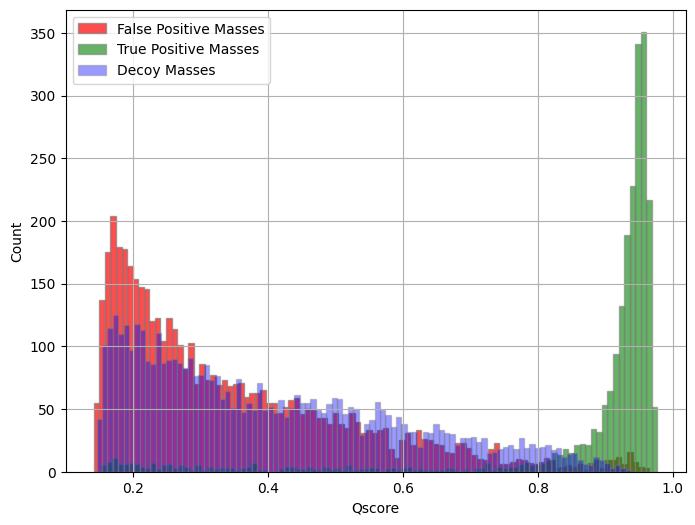

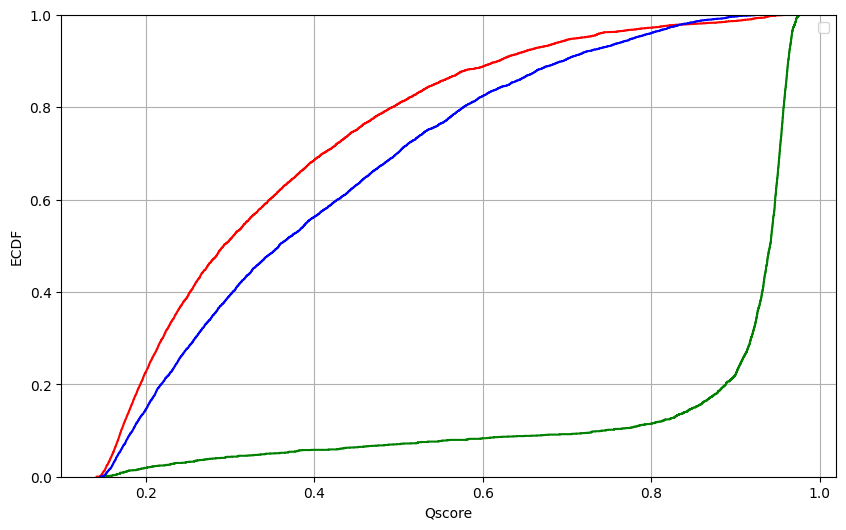

<ipython-input-13-b4332abbc143>:95: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=combined_df.loc[tpindex, 'Qscore'], shade=True,color='green')
<ipython-input-13-b4332abbc143>:96: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=combined_df.loc[fpindex, 'Qscore'], shade=True, color='red')
<ipython-input-13-b4332abbc143>:97: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=combined_df.loc[decoyindex, 'Qscore'], shade=True,color='blue')


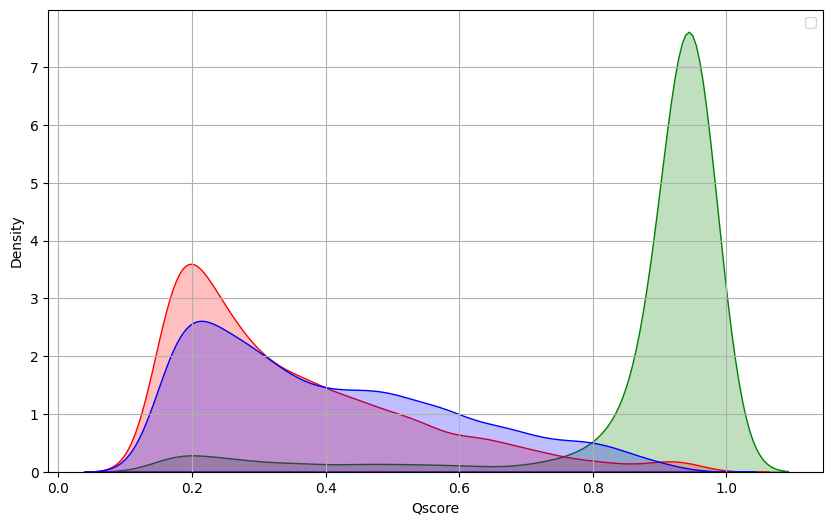

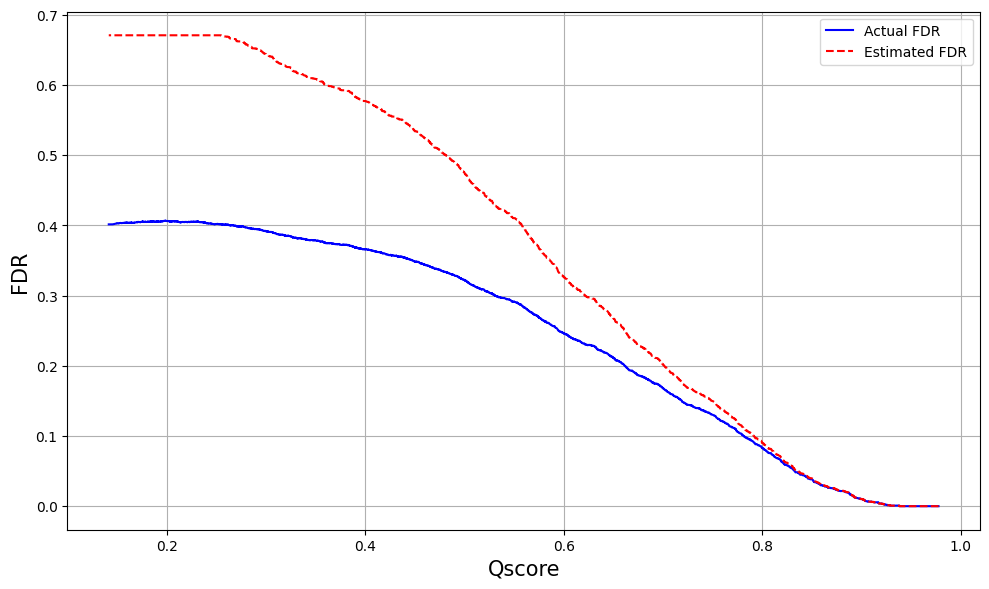

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the input files into pandas dataframes
combined_path = '/content/adder_res70k_1e5_iso1.tsv'
original_path = '/content/chosen.csv'

combined_df = pd.read_csv(combined_path, sep='\t')
original_df = pd.read_csv(original_path)

# Define the tolerance limit in parts per million
ppmtol = 5

# Create the fdval dataframe by combining the ScanNum and MonoisotopicMass columns from the combined_df
fdval = combined_df[['ScanNum', 'MonoisotopicMass']]

# Convert the ScanNum column to integers
fdval['ScanNum'] = fdval['ScanNum'].astype(int)

# Create the tpindex1 logical index by checking if the values in the ScanNum column of fdval are present in the Scan column of original_df
tpindex1 = fdval['ScanNum'].isin(original_df['ScanNum'].dropna().replace([np.inf, -np.inf], np.nan).astype(int))

# Adjusted code to allow for ±1 Da error with 0.1 Da tolerance
tpindex2 = np.logical_or.reduce([
    (fdval.iloc[:, 1].values[:, np.newaxis] >= original_df.iloc[:, 2].values - 0.1) &
     (fdval.iloc[:, 1].values[:, np.newaxis] <= original_df.iloc[:, 2].values + 0.1),
     (fdval.iloc[:, 1].values[:, np.newaxis] >= original_df.iloc[:, 2].values - 1.1) &
     (fdval.iloc[:, 1].values[:, np.newaxis] <= original_df.iloc[:, 2].values - 0.9),
     (fdval.iloc[:, 1].values[:, np.newaxis] >= original_df.iloc[:, 2].values + 0.9) &
     (fdval.iloc[:, 1].values[:, np.newaxis] <= original_df.iloc[:, 2].values + 1.1)
 ])


# Create the tpindex logical index by combining tpindex1, tpindex2, and the DummyIndex column from combined_df with values of 0
tpindex = np.logical_and.reduce((
    tpindex1.values.flatten(),
    tpindex2.any(axis=1),
    combined_df['TargetDecoyType'].values == 0
))


# Identify false positives and decoys
fpindex = np.logical_and.reduce((
    np.logical_not(tpindex),
    combined_df['TargetDecoyType'].values == 0
))
decoyindex = combined_df['TargetDecoyType'] > 0

# Plotting the histograms, ECDF, and KDE
plt.figure(figsize=(8,6))
plt.hist(combined_df.loc[fpindex, 'Qscore'], bins=100, alpha=0.7, label='False Positive Masses', color='red', edgecolor='grey')
plt.hist(combined_df.loc[tpindex, 'Qscore'], bins=100, alpha=0.6, label='True Positive Masses', color='green', edgecolor='grey')
plt.hist(combined_df.loc[decoyindex, 'Qscore'], bins=100, alpha=0.4, label='Decoy Masses', color='blue', edgecolor='grey')
plt.xlabel('Qscore')
plt.ylabel('Count')
#plt.title('Histogram of Qscore,res=70k,noise=0')
plt.legend()
plt.grid(True)
plt.show()

#plt.figure(figsize=(10, 6))
#sns.ecdfplot(data=combined_df.loc[tpindex, 'Qscore'], label='True Positive Masses', color='green')
#sns.ecdfplot(data=combined_df.loc[fpindex, 'Qscore'], label='False Positive Masses', color='red')
#sns.ecdfplot(data=combined_df.loc[decoyindex, 'Qscore'], label='Decoy Masses', color='blue')
#plt.xlabel('Qscore')
#plt.ylabel('ECDF')
#plt.title('Empirical Cumulative Distribution Function,res=35k,noise=1e3')
#plt.legend()
#plt.show()

plt.figure(figsize=(10, 6))
sns.ecdfplot(data=combined_df.loc[tpindex, 'Qscore'], color='green')
sns.ecdfplot(data=combined_df.loc[fpindex, 'Qscore'], color='red')
sns.ecdfplot(data=combined_df.loc[decoyindex, 'Qscore'], color='blue')
plt.xlabel('Qscore')
plt.ylabel('ECDF')
#plt.title('Empirical Cumulative Distribution Function,res=140k,noise=1e5')
plt.legend()
plt.grid(True)
plt.show()

#plt.figure(figsize=(10, 6))
#sns.kdeplot(data=combined_df.loc[tpindex, 'Qscore'], label='True Positive Masses', shade=True,color='green')
#sns.kdeplot(data=combined_df.loc[fpindex, 'Qscore'], label='False Positive Masses', shade=True, color='red')
#sns.kdeplot(data=combined_df.loc[decoyindex, 'Qscore'], label='Decoy Masses', shade=True,color='blue')
#plt.xlabel('Qscore')
#plt.ylabel('Density')
#plt.title('Kernel Density Estimate')
#plt.legend()
#plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=combined_df.loc[tpindex, 'Qscore'], shade=True,color='green')
sns.kdeplot(data=combined_df.loc[fpindex, 'Qscore'], shade=True, color='red')
sns.kdeplot(data=combined_df.loc[decoyindex, 'Qscore'], shade=True,color='blue')
plt.xlabel('Qscore')
plt.ylabel('Density')
#plt.title('Res140k,noise 1e5')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the cumulative number of targets and decoys
combined_df_sorted = combined_df.sort_values('Qscore', ascending=False)
combined_df_sorted['cumulative_targets'] = np.cumsum(combined_df_sorted['TargetDecoyType'] == 0)
combined_df_sorted['cumulative_decoys'] = np.cumsum(combined_df_sorted['TargetDecoyType'] > 0)

# Calculate FDR and q-values
combined_df_sorted['FDR'] = combined_df_sorted['cumulative_decoys'] / combined_df_sorted['cumulative_targets']
combined_df_sorted['q_value'] = combined_df_sorted['FDR'][::-1].cummin()[::-1]



# Calculate actual FDR: the proportion of decoy matches at each score threshold
combined_df_sorted['actual_FDR'] = combined_df_sorted['cumulative_decoys'] / (combined_df_sorted['cumulative_targets'] + combined_df_sorted['cumulative_decoys'])

# Estimated FDR can be taken from the previously calculated q-values
combined_df_sorted['estimated_FDR'] = combined_df_sorted['q_value']  # assuming q_value is the estimated FDR

# Now plot both actual FDR and estimated FDR against Qscore
plt.figure(figsize=(10, 6))

# Plot for actual FDR
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['actual_FDR'], color='blue', label='Actual FDR')

# Plot for estimated FDR from q-values
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['estimated_FDR'], color='red', linestyle='--', label='Estimated FDR')

plt.xlabel('Qscore', fontsize=15)
plt.ylabel('FDR', fontsize=15)
#plt.title('Actual vs Estimated FDR', fontsize=15)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load the TSV file into a DataFrame
tsv_file = "/content/CA,res240k,noise1e3,b,y_centroid_ms2.tsv"
df = pd.read_csv(tsv_file, sep='\t')

# Store the DataFrame as a CSV file
csv_file = "/content/CA,res240k,noise1e3,b,y_centroid_ms2.csv"
df.to_csv(csv_file, index=False)

print(f"TSV file '{tsv_file}' has been converted to CSV file '{csv_file}'.")

TSV file '/content/CA,res240k,noise1e3,b,y_centroid_ms2.tsv' has been converted to CSV file '/content/CA,res240k,noise1e3,b,y_centroid_ms2.csv'.


In [ ]:
import pandas as pd

# Load the TSV file into a DataFrame
tsv_file = "/content/CA,res240k,noise1e3,c,z_centroid_ms2.tsv"
df = pd.read_csv(tsv_file, sep='\t')

# Store the DataFrame as a CSV file

csv_file = "/content/CA,res240k,noise1e3,c,z_centroid_ms2.csv"

df.to_csv(csv_file, index=False)

print(f"TSV file '{tsv_file}' has been converted to CSV file '{csv_file}'.")


TSV file '/content/CA,res240k,noise1e3,c,z_centroid_ms2.tsv' has been converted to CSV file '/content/CA,res240k,noise1e3,c,z_centroid_ms2.csv'.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load File A and File B
file_a = pd.read_csv('/Users/ayeshaferoz/Documents/Res=35k,noise=0/Files/charge separate columnsZ.csv')
file_b = pd.read_csv('/Users/ayeshaferoz/Documents/Res=140k,noise=1e5/adderZ.csv')
ppmtol= 10
fdval= file_b[['ScanNum','MonoisotopicMass']]
fdval.loc[:, 'ScanNum']= fdval ['ScanNum']
print(fdval.iloc[:,1])
original_scan_nums = file_a['ScanNum'].dropna().replace([np.inf, -np.inf], np.nan).astype(float)
tpindex1 = fdval['ScanNum'].isin(original_scan_nums)
def ppm_dif(value1, value2):
    return abs(value1-value2)/value1*1e6
tpindex2 = np.isclose(pd.to_numeric(fdval.iloc[:,1], errors='coerce')[:, np.newaxis], pd.to_numeric(file_a.iloc[:,1], errors='coerce'), rtol=ppmtol/1e6, atol=0)

#tpindex2 = np.isclose(fdval.iloc[:,1][:, np.newaxis],original_df.iloc[:,1],rtol=ppmtol/1e6,atol=0)
tpindex= np.logical_and.reduce((
    tpindex1.values.flatten(),
    tpindex2.any(axis=1),
    combined_df['DummyIndex'].values==0
))
print(tpindex)
# Merge File A and File B on MonoisotopicMass and Charge
merged = pd.merge(file_b, file_a, on=['MonoisotopicMass', 'Z'], how='left')

# Only consider entries in File B where DummyIndex = 0
merged = merged.loc[merged['DummyIndex'] == 0]

# Calculate the expected m/z value
merged['Expected m/z'] = merged['MonoisotopicMass'] / merged['Z']

# Calculate the observed m/z value based on the Charge state
merged['m/z'] = (merged['MonoisotopicMass'] + (merged['Z'] - 1) * 1.00727646677) / merged['Z']

# Calculate the difference in m/z values between the observed and expected values
merged['DeltaM/Z'] = merged['m/z'] - merged['Expected m/z']

# Convert the difference in m/z to a mass difference
merged['DeltaMass'] = merged['DeltaM/Z'] * merged['Z']

# Set a threshold for false positive mass errors
threshold = 40
# Calculate False positive class 1
# Filter the merged DataFrame to only include entries with DeltaMass > threshold
false_positives_1 = merged.loc[merged['DeltaMass'].abs() > threshold]

# Calculate the decoy masses based on QScore of file_b whose MonoisotopicMass has DummyIndex > 0
decoy_masses = file_b.loc[(file_b['DummyIndex'] > 0) & (file_b['QScore'] > 0), ['MonoisotopicMass', 'QScore']]
decoy_masses['DeltaMass'] = decoy_masses['MonoisotopicMass'] - 1.00727646677

# Calculate False Positive Class 2
merged_2 = pd.merge(file_b.loc[file_b['DummyIndex'] == 0], file_a, on='ScanNum', how='inner')
merged_2['DeltaMass'] = (merged_2['MonoisotopicMass_y'] - merged_2['MonoisotopicMass_x']).abs()
false_positives_2 = merged_2.loc[merged_2['DeltaMass'] <= np.sqrt(7.0)/2.0, ['MonoisotopicMass_y', 'QScore']]
false_positives_2.columns = ['MonoisotopicMass', 'QScore']

#Calculate False Positive Class 3


# Plot the false positives and decoy masses based on their QScore
plt.figure(figsize=(10,8))
plt.hist(false_positives_1['QScore'], bins=100, alpha=0.9, label='False Positives Class 1', color='red')
plt.hist(false_positives_2['QScore'], bins=100, alpha=0.5, label='False Positives Class 2', color='yellow')
plt.hist(combined_df.loc[tpindex, 'QScore'],bins=80, alpha=0.4, label = 'True positive', color ='green')
plt.hist(decoy_masses['QScore'], bins=100, alpha=0.4, label='Dummy Masses', color='blue')
plt.xlabel('QScore', fontsize=19)
plt.ylabel('Count', fontsize=19)
plt.title('False Positives and Dummy Masses based on QScore', fontsize=22)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load File A and File B
file_a = pd.read_csv('/Users/ayeshaferoz/Documents/Res=35k,noise=0/Files/charge separate columnsZ.csv')
file_b = pd.read_csv('/Users/ayeshaferoz/Documents/Res=140k,noise=1e5/adderZ.csv')
ppmtol= 10
fdval= file_b[['ScanNum','MonoisotopicMass']]
fdval.loc[:, 'ScanNum']= fdval ['ScanNum']

original_scan_nums = file_a['ScanNum'].dropna().replace([np.inf, -np.inf], np.nan).astype(float)
tpindex1 = fdval['ScanNum'].isin(original_scan_nums)
def ppm_dif(value1, value2):
    return abs(value1-value2)/value1*1e6
tpindex2 = np.isclose(pd.to_numeric(fdval.iloc[:,1], errors='coerce')[:, np.newaxis], pd.to_numeric(file_a.iloc[:,1], errors='coerce'), rtol=ppmtol/1e6, atol=0)

#tpindex2 = np.isclose(fdval.iloc[:,1][:, np.newaxis],original_df.iloc[:,1],rtol=ppmtol/1e6,atol=0)
tpindex= np.logical_and.reduce((
    tpindex1.values.flatten(),
    tpindex2.any(axis=1),
    combined_df['TargetDecoyType'].values==0
))
Z= file_a['MaxCharge'-'MaxCharge']
# Merge File A and File B on MonoisotopicMass and Charge
merged = pd.merge(file_b, file_a, on=['MonoisotopicMass', 'Z'], how='left')

# Only consider entries in File B where DummyIndex = 0
merged = merged.loc[merged['TargetDecoyType'] == 0]

# Calculate the expected m/z value
merged['Expected m/z'] = merged['MonoisotopicMass'] / merged['Z']

# Calculate the observed m/z value based on the Charge state
merged['m/z'] = (merged['MonoisotopicMass'] + (merged['Z'] - 1) * 1.00727646677) / merged['Z']

# Calculate the difference in m/z values between the observed and expected values
merged['DeltaM/Z'] = merged['m/z'] - merged['Expected m/z']

# Convert the difference in m/z to a mass difference
merged['DeltaMass'] = merged['DeltaM/Z'] * merged['Z']

# Set a threshold for false positive mass errors
threshold = 40
# Calculate False positive class 1
# Filter the merged DataFrame to only include entries with DeltaMass > threshold
false_positives_1 = merged.loc[merged['DeltaMass'].abs() > threshold]

# Calculate the decoy masses based on QScore of file_b whose MonoisotopicMass has DummyIndex > 0
decoy_masses = file_b.loc[(file_b['TargetDecoyType'] > 0) & (file_b['Qscore'] > 0), ['MonoisotopicMass', 'Qscore']]
decoy_masses['DeltaMass'] = decoy_masses['MonoisotopicMass'] - 1.00727646677

# Calculate False Positive Class 2
merged_2 = pd.merge(file_b.loc[file_b['TargetDecoyType'] == 0], file_a, on='ScanNum', how='inner')
merged_2['DeltaMass'] = (merged_2['MonoisotopicMass_y'] - merged_2['MonoisotopicMass_x']).abs()
false_positives_2 = merged_2.loc[merged_2['DeltaMass'] <= np.sqrt(7.0)/2.0, ['MonoisotopicMass_y', 'Qscore']]
false_positives_2.columns = ['MonoisotopicMass', 'Qscore']

#Calculate False Positive Class 3


# Plot the false positives and decoy masses based on their QScore
plt.figure(figsize=(10,8))
plt.hist(false_positives_1['Qscore'], bins=100, alpha=0.9, label='False Positives Class 1', color='red')
plt.hist(false_positives_2['Qscore'], bins=100, alpha=0.5, label='False Positives Class 2', color='yellow')
plt.hist(combined_df.loc[tpindex, 'Qscore'],bins=80, alpha=0.4, label = 'True positive', color ='green')
plt.hist(decoy_masses['Qscore'], bins=100, alpha=0.4, label='Dummy Masses', color='blue')
plt.xlabel('Qscore', fontsize=19)
plt.ylabel('Count', fontsize=19)
plt.title('False Positives and Dummy Masses based on QScore', fontsize=22)
plt.legend()
plt.show()

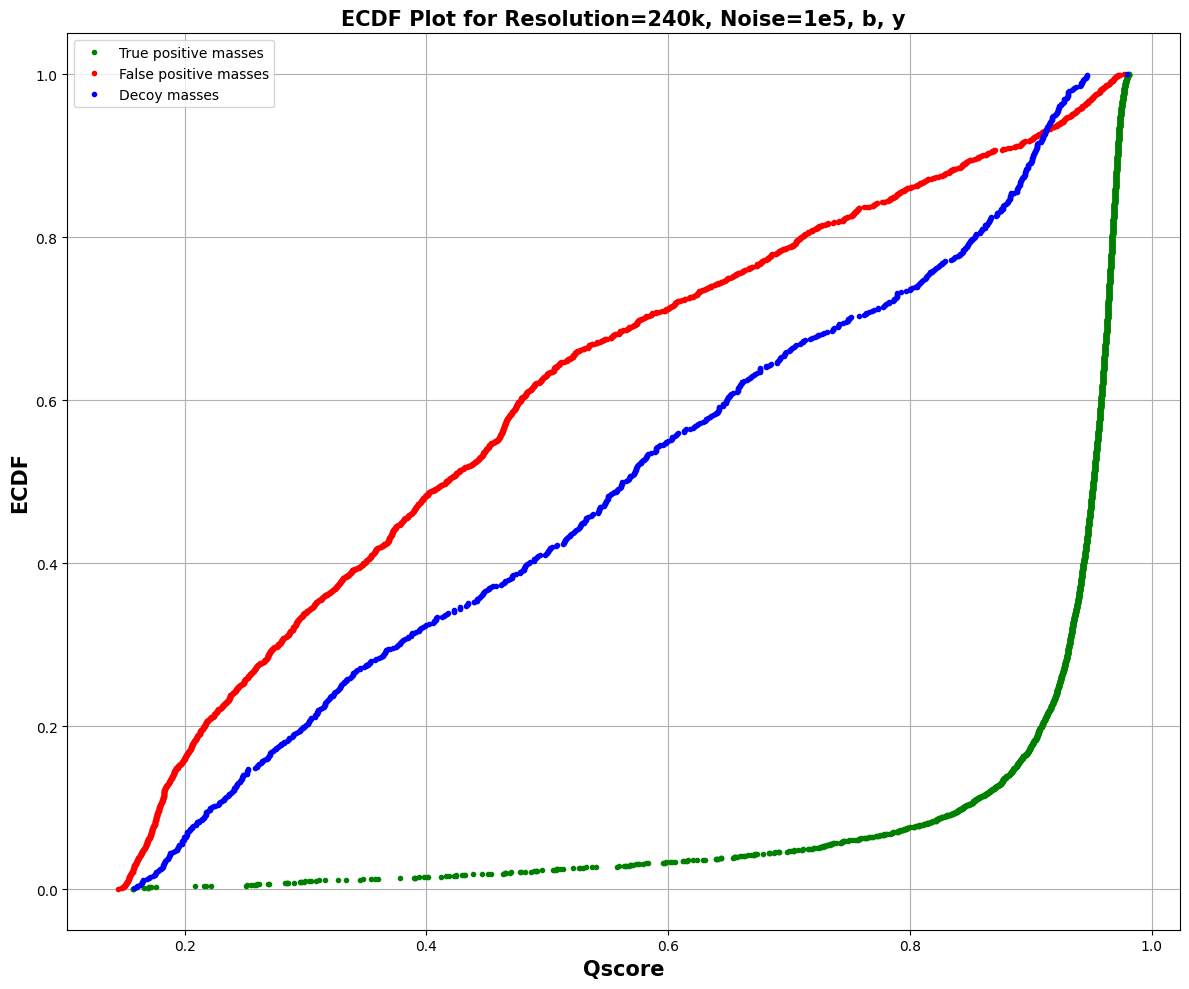

3547
1803
5350


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the deconvolved CSV file
deconvolved_df = pd.read_csv('/content/adder_res70k_1e3.tsv', sep='\t')  # Replace with the path to your deconvolved CSV file

# Load the true masses CSV file
true_masses_df = pd.read_csv('/content/chosen.csv')  # Replace with the path to your true masses CSV file

# Define ppm tolerance
ppm_tolerance = 10  # Adjust as needed

# Filter deconvolved_df for rows where TargetDummyType is 0
filtered_deconvolved_df = deconvolved_df[deconvolved_df['TargetDecoyType'] == 0]

# Initialize empty lists for true positives, false positives, and dummy masses
true_positives = []
false_positives = []
dummy_masses = []

# Iterate through rows in filtered_deconvolved_df
for index, row in filtered_deconvolved_df.iterrows():
    # Calculate ppm difference between each MonoisotopicMass in filtered_deconvolved_df
    # and true_masses_df and check if it's within ppm_tolerance or ±1 isotope error with 0.1 Da tolerance
    ppm_diff = abs(row['MonoisotopicMass'] - true_masses_df['MonoisotopicMass']) / true_masses_df['MonoisotopicMass'] * 1e6
    isotope_error_condition = (
        (ppm_diff <= ppm_tolerance) |
        ((row['MonoisotopicMass'] >= true_masses_df['MonoisotopicMass'] - 0.1) &
         (row['MonoisotopicMass'] <= true_masses_df['MonoisotopicMass'] + 0.1)) |
        ((row['MonoisotopicMass'] >= true_masses_df['MonoisotopicMass'] - 1.1) &
         (row['MonoisotopicMass'] <= true_masses_df['MonoisotopicMass'] - 0.9)) |
        ((row['MonoisotopicMass'] >= true_masses_df['MonoisotopicMass'] + 0.9) &
         (row['MonoisotopicMass'] <= true_masses_df['MonoisotopicMass'] + 1.1))
    )
    matches_within_tolerance = any(isotope_error_condition)

    # Classify the rows based on matching criteria
    if matches_within_tolerance:
        true_positives.append(row)
    else:
        false_positives.append(row)


# Filter the deconvolved_df for rows where TargetDummyType is greater than 0
dummy_masses_df = deconvolved_df[deconvolved_df['TargetDecoyType'] > 0]

# Convert true_positives and false_positives to dataframes
true_positives_df = pd.DataFrame(true_positives)
false_positives_df = pd.DataFrame(false_positives)

# Create ECDF plots based on Qscore
plt.figure(figsize=(12, 10))

# Function to calculate ECDF
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y

# Create ECDF plots for True Positives, False Positives, and Dummy Masses
for data, label, color in [(true_positives_df['Qscore'], 'True positive masses', 'green'),
                           (false_positives_df['Qscore'], 'False positive masses', 'red'),
                           (dummy_masses_df['Qscore'], 'Decoy masses', 'blue')]:
    x, y = ecdf(data)
    plt.plot(x, y, marker='.', linestyle='none', label=label, color=color)

plt.xlabel('Qscore', fontsize=15, fontweight='bold')
plt.ylabel('ECDF', fontsize=15, fontweight='bold')
plt.title('ECDF Plot for Resolution=240k, Noise=1e5, b, y', fontsize=15, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(len(true_positives_df))
print(len(false_positives_df))
print(len(filtered_deconvolved_df))

<ipython-input-7-cec6ae1d4b8b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdval['ScanNum'] = fdval['ScanNum'].astype(int)


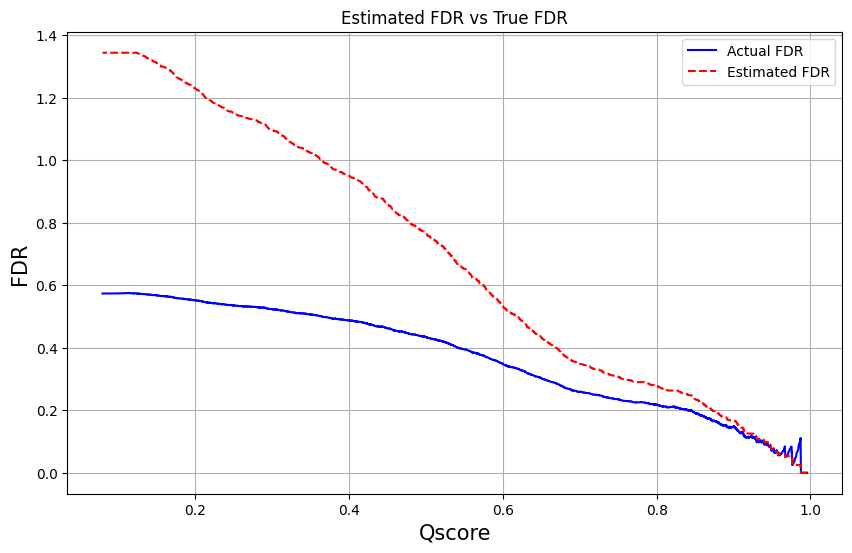

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data
combined_path = '/content/res35noise1e5centroid_ms1.tsv'  # Change to your actual file path
original_path = '/content/chosen.csv'  # Ground truth file

combined_df = pd.read_csv(combined_path, sep='\t')
original_df = pd.read_csv(original_path)

# Define ppm tolerance
ppmtol = 10

# Extract relevant data
fdval = combined_df[['ScanNum', 'MonoisotopicMass']]
fdval['ScanNum'] = fdval['ScanNum'].astype(int)

# Identify true positives
tpindex1 = fdval['ScanNum'].isin(original_df['ScanNum'].dropna().astype(int))

# Use ±1 Da error tolerance
tpindex2 = np.logical_or.reduce([
    (fdval['MonoisotopicMass'].values[:, None] >= original_df.iloc[:, 2].values - 0.1) &
    (fdval['MonoisotopicMass'].values[:, None] <= original_df.iloc[:, 2].values + 0.1),
    (fdval['MonoisotopicMass'].values[:, None] >= original_df.iloc[:, 2].values - 1.1) &
    (fdval['MonoisotopicMass'].values[:, None] <= original_df.iloc[:, 2].values - 0.9),
    (fdval['MonoisotopicMass'].values[:, None] >= original_df.iloc[:, 2].values + 0.9) &
    (fdval['MonoisotopicMass'].values[:, None] <= original_df.iloc[:, 2].values + 1.1)
])

# Identify TP, FP, and Decoy indexes
tpindex = np.logical_and.reduce((
    tpindex1.values.flatten(),
    tpindex2.any(axis=1),
    combined_df['TargetDecoyType'].values == 0
))

fpindex = np.logical_and(~tpindex, combined_df['TargetDecoyType'].values == 0)
decoyindex = combined_df['TargetDecoyType'] > 0

# Sort by Qscore
combined_df_sorted = combined_df.sort_values('Qscore', ascending=False)

# Compute cumulative targets and decoys
combined_df_sorted['cumulative_targets'] = np.cumsum(combined_df_sorted['TargetDecoyType'] == 0)
combined_df_sorted['cumulative_decoys'] = np.cumsum(combined_df_sorted['TargetDecoyType'] > 0)

# Compute FDR and q-values
combined_df_sorted['FDR'] = combined_df_sorted['cumulative_decoys'] / combined_df_sorted['cumulative_targets']
combined_df_sorted['q_value'] = combined_df_sorted['FDR'][::-1].cummin()[::-1]

# Compute True FDR
combined_df_sorted['actual_FDR'] = combined_df_sorted['cumulative_decoys'] / (
        combined_df_sorted['cumulative_targets'] + combined_df_sorted['cumulative_decoys'])

# Estimated FDR
combined_df_sorted['estimated_FDR'] = combined_df_sorted['q_value']

# Plot True vs Estimated FDR
plt.figure(figsize=(10, 6))

# Actual FDR plot
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['actual_FDR'], label='Actual FDR', color='blue')

# Estimated FDR plot
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['estimated_FDR'], linestyle='--', label='Estimated FDR',
         color='red')

plt.xlabel('Qscore', fontsize=15)
plt.ylabel('FDR', fontsize=15)
plt.legend()
plt.grid(True)
plt.title('Estimated FDR vs True FDR')
plt.show()


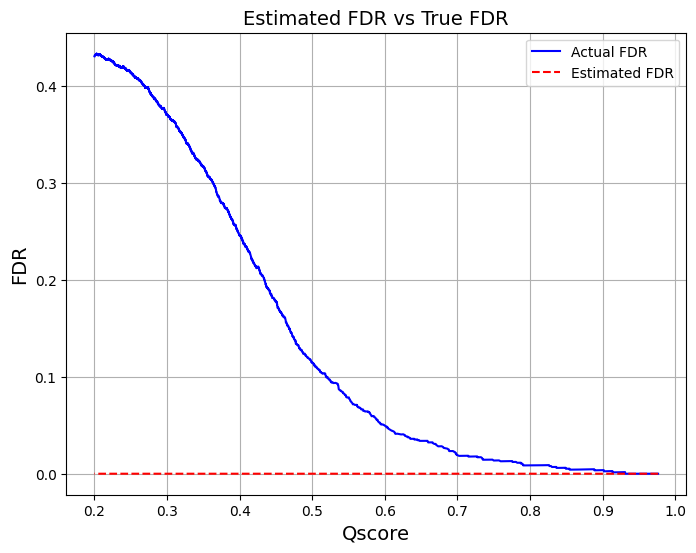

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read your input files
combined_df = pd.read_csv("/content/combined.tsv", sep='\t')

# Sorting by Qscore in descending order
combined_df_sorted = combined_df.sort_values('Qscore', ascending=False)

# Compute cumulative targets and decoys
combined_df_sorted['cumulative_targets'] = np.cumsum(combined_df_sorted['TargetDecoyType'] == 0)
combined_df_sorted['cumulative_decoys'] = np.cumsum(combined_df_sorted['TargetDecoyType'] > 0)

# Compute actual FDR
combined_df_sorted['actual_FDR'] = combined_df_sorted['cumulative_decoys'] / (
    combined_df_sorted['cumulative_targets'] + combined_df_sorted['cumulative_decoys']
)

# Compute estimated FDR (q-values) using min cumulative approach
combined_df_sorted['estimated_FDR'] = np.minimum.accumulate(
    combined_df_sorted['cumulative_decoys'] / np.where(combined_df_sorted['cumulative_targets'] > 0,
                                                       combined_df_sorted['cumulative_targets'], 1)
)

# Plot the FDR curves
plt.figure(figsize=(8, 6))
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['actual_FDR'], color='blue', label='Actual FDR')
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['estimated_FDR'], color='red', linestyle='--', label='Estimated FDR')

plt.xlabel('Qscore', fontsize=14)
plt.ylabel('FDR', fontsize=14)
plt.title('Estimated FDR vs True FDR', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


        Qscore  cumulative_decoys  cumulative_targets
6199  0.976297                  0                   1
6186  0.976126                  0                   2
6191  0.975830                  0                   3
6064  0.975350                  0                   4
6189  0.975014                  0                   5
6200  0.974701                  0                   6
1697  0.974493                  0                   7
4681  0.974212                  0                   8
6067  0.973900                  0                   9
553   0.973685                  0                  10
6063  0.973678                  0                  11
6194  0.973364                  0                  12
6198  0.973306                  0                  13
6197  0.973188                  0                  14
6187  0.973124                  0                  15
4685  0.972770                  0                  16
4497  0.972710                  0                  17
5965  0.972581              

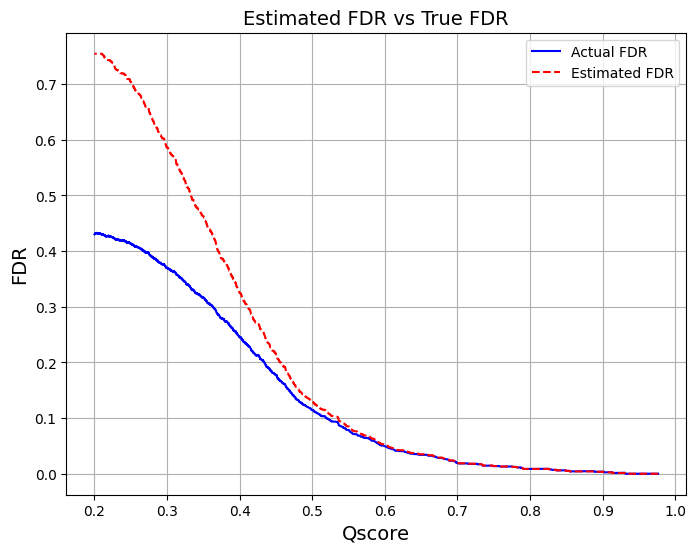

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read input data
combined_df = pd.read_csv("/content/combined.tsv", sep='\t')

# Sort by descending Qscore
combined_df_sorted = combined_df.sort_values('Qscore', ascending=False)

# Compute cumulative targets and decoys
combined_df_sorted['cumulative_targets'] = np.cumsum(combined_df_sorted['TargetDecoyType'] == 0)
combined_df_sorted['cumulative_decoys'] = np.cumsum(combined_df_sorted['TargetDecoyType'] > 0)

# Check if decoys exist at different levels
print(combined_df_sorted[['Qscore', 'cumulative_decoys', 'cumulative_targets']].head(20))

# Compute actual FDR
combined_df_sorted['actual_FDR'] = combined_df_sorted['cumulative_decoys'] / (
    combined_df_sorted['cumulative_targets'] + combined_df_sorted['cumulative_decoys']
)

# Compute estimated FDR with proper handling
combined_df_sorted['estimated_FDR'] = np.where(
    combined_df_sorted['cumulative_targets'] > 0,
    combined_df_sorted['cumulative_decoys'] / combined_df_sorted['cumulative_targets'],
    np.nan  # Avoid division by zero
)

# Apply cumulative minimum to match q-value logic in MATLAB
combined_df_sorted['estimated_FDR'] = combined_df_sorted['estimated_FDR'][::-1].cummin()[::-1]

# Plot estimated vs actual FDR
plt.figure(figsize=(8, 6))
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['actual_FDR'], color='blue', label='Actual FDR')
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['estimated_FDR'], color='red', linestyle='--', label='Estimated FDR')

plt.xlabel('Qscore', fontsize=14)
plt.ylabel('FDR', fontsize=14)
plt.title('Estimated FDR vs True FDR', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-6-1f3f6d3ef9f1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdval['ScanNum'] = fdval['ScanNum'].astype(int)


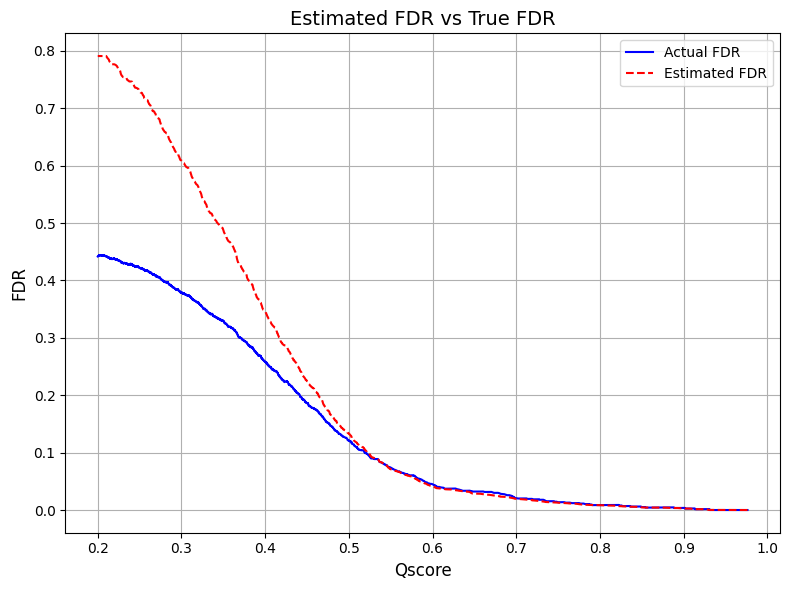

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (replace with your actual file paths)
combined_path = '/content/mergedfile_ms1.tsv'
original_path = 'chosen.csv'

combined_df = pd.read_csv(combined_path, sep='\t')
original_df = pd.read_csv(original_path)

# Define ppm tolerance
ppmtol = 10

# Extract ScanNum and MonoisotopicMass from combined_df
fdval = combined_df[['ScanNum', 'MonoisotopicMass']]
fdval['ScanNum'] = fdval['ScanNum'].astype(int)

# Identify true positives based on ScanNum matching
tpindex1 = fdval['ScanNum'].isin(original_df['ScanNum'].dropna().replace([np.inf, -np.inf], np.nan).astype(int))

# Allow for ±1 Da error with 0.1 Da tolerance
tpindex2 = np.logical_or.reduce([
    (fdval.iloc[:, 1].values[:, np.newaxis] >= original_df.iloc[:, 2].values - 0.1) &
    (fdval.iloc[:, 1].values[:, np.newaxis] <= original_df.iloc[:, 2].values + 0.1),
    (fdval.iloc[:, 1].values[:, np.newaxis] >= original_df.iloc[:, 2].values - 1.1) &
    (fdval.iloc[:, 1].values[:, np.newaxis] <= original_df.iloc[:, 2].values - 0.9),
    (fdval.iloc[:, 1].values[:, np.newaxis] >= original_df.iloc[:, 2].values + 0.9) &
    (fdval.iloc[:, 1].values[:, np.newaxis] <= original_df.iloc[:, 2].values + 1.1)
])

# Final true positive index
tpindex = np.logical_and.reduce((
    tpindex1.values.flatten(),
    tpindex2.any(axis=1),
    combined_df['TargetDecoyType'].values == 0
))

# Identify false positives and decoys
fpindex = np.logical_and.reduce((
    np.logical_not(tpindex),
    combined_df['TargetDecoyType'].values == 0
))
decoyindex = combined_df['TargetDecoyType'] > 0

# Sort data by Qscore
combined_df_sorted = combined_df.sort_values('Qscore', ascending=False)

# Compute cumulative targets and decoys
combined_df_sorted['cumulative_targets'] = np.cumsum(combined_df_sorted['TargetDecoyType'] == 0)
combined_df_sorted['cumulative_decoys'] = np.cumsum(combined_df_sorted['TargetDecoyType'] > 0)

# Compute actual FDR
combined_df_sorted['actual_FDR'] = combined_df_sorted['cumulative_decoys'] / (combined_df_sorted['cumulative_targets'] + combined_df_sorted['cumulative_decoys'])

# Compute estimated FDR (q-value)
combined_df_sorted['estimated_FDR'] = (combined_df_sorted['cumulative_decoys'] / combined_df_sorted['cumulative_targets'])
combined_df_sorted['estimated_FDR'] = combined_df_sorted['estimated_FDR'][::-1].cummin()[::-1]

# **Apply rolling mean smoothing to Estimated FDR**
combined_df_sorted['estimated_FDR'] = combined_df_sorted['estimated_FDR'].rolling(window=30, min_periods=1).mean()

# Plot Actual FDR vs Estimated FDR
plt.figure(figsize=(8,6))
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['actual_FDR'], color='blue', label='Actual FDR')
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['estimated_FDR'], color='red', linestyle='--', label='Estimated FDR')

plt.xlabel('Qscore', fontsize=12)
plt.ylabel('FDR', fontsize=12)
plt.title('Estimated FDR vs True FDR', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-4-27840dc309c4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdval['ScanNum'] = fdval['ScanNum'].astype(int)


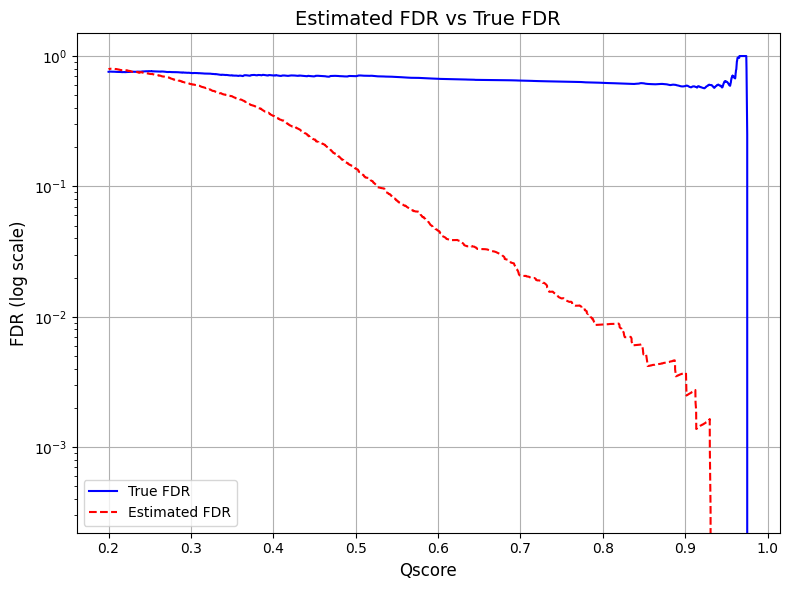

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (replace with your actual file paths)
combined_path = '/content/mergedfile_ms1.tsv'
original_path = 'chosen.csv'

combined_df = pd.read_csv(combined_path, sep='\t')
original_df = pd.read_csv(original_path)

# Define ppm tolerance
ppmtol = 10

# Extract ScanNum and MonoisotopicMass from combined_df
fdval = combined_df[['ScanNum', 'MonoisotopicMass']]
fdval['ScanNum'] = fdval['ScanNum'].astype(int)

# Identify true positives based on ScanNum matching
tpindex1 = fdval['ScanNum'].isin(original_df['ScanNum'].dropna().replace([np.inf, -np.inf], np.nan).astype(int))

# Allow for ±1 Da error with 0.1 Da tolerance
tpindex2 = np.logical_or.reduce([
    (fdval.iloc[:, 1].values[:, np.newaxis] >= original_df.iloc[:, 2].values - 0.1) &
    (fdval.iloc[:, 1].values[:, np.newaxis] <= original_df.iloc[:, 2].values + 0.1),
    (fdval.iloc[:, 1].values[:, np.newaxis] >= original_df.iloc[:, 2].values - 1.1) &
    (fdval.iloc[:, 1].values[:, np.newaxis] <= original_df.iloc[:, 2].values - 0.9),
    (fdval.iloc[:, 1].values[:, np.newaxis] >= original_df.iloc[:, 2].values + 0.9) &
    (fdval.iloc[:, 1].values[:, np.newaxis] <= original_df.iloc[:, 2].values + 1.1)
])

# Final true positive index
tpindex = np.logical_and.reduce((
    tpindex1.values.flatten(),
    tpindex2.any(axis=1),
    combined_df['TargetDecoyType'].values == 0
))

# Identify false positives and decoys
fpindex = np.logical_and.reduce((
    np.logical_not(tpindex),
    combined_df['TargetDecoyType'].values == 0
))
decoyindex = combined_df['TargetDecoyType'] > 0

# Sort data by Qscore
combined_df_sorted = combined_df.sort_values('Qscore', ascending=False)

# Compute cumulative targets and decoys
combined_df_sorted['cumulative_targets'] = np.cumsum(combined_df_sorted['TargetDecoyType'] == 0)
combined_df_sorted['cumulative_decoys'] = np.cumsum(combined_df_sorted['TargetDecoyType'] > 0)

# Compute True FDR, avoid zero division with a small epsilon and validate values
epsilon = 1e-6
combined_df_sorted['true_FDR'] = np.cumsum(fpindex) / (np.cumsum(tpindex) + np.cumsum(fpindex) + epsilon)

# Ensure True FDR stays in range [0, 1]
combined_df_sorted['true_FDR'] = np.clip(combined_df_sorted['true_FDR'], 0, 1)

# Compute Estimated FDR (using Decoy masses as a proxy for False Positives)
combined_df_sorted['estimated_FDR'] = combined_df_sorted['cumulative_decoys'] / combined_df_sorted['cumulative_targets']

# Apply smoothing to both True FDR and Estimated FDR using a moving average
window_size = 5  # Reduce smoothing window size
combined_df_sorted['estimated_FDR'] = combined_df_sorted['estimated_FDR'].rolling(window=window_size, min_periods=1).mean()
combined_df_sorted['true_FDR'] = combined_df_sorted['true_FDR'].rolling(window=window_size, min_periods=1).mean()

# Cap extreme values in Estimated FDR and True FDR (e.g., limit to max 1)
combined_df_sorted['estimated_FDR'] = np.clip(combined_df_sorted['estimated_FDR'], 0, 1)
combined_df_sorted['true_FDR'] = np.clip(combined_df_sorted['true_FDR'], 0, 1)

# Plot Actual FDR vs Estimated FDR on a log scale for better visualization of differences
plt.figure(figsize=(8,6))
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['true_FDR'], color='blue', label='True FDR')
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['estimated_FDR'], color='red', linestyle='--', label='Estimated FDR')

# Set log scale to manage the difference
plt.yscale('log')

plt.xlabel('Qscore', fontsize=12)
plt.ylabel('FDR (log scale)', fontsize=12)
plt.title('Estimated FDR vs True FDR', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-5-d1097a6cdc75>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdval['ScanNum'] = fdval['ScanNum'].astype(int)
<ipython-input-5-d1097a6cdc75>:54: RuntimeWarning: invalid value encountered in divide
  combined_df_sorted['true_FDR'] = np.cumsum(fpindex) / (np.cumsum(tpindex) + np.cumsum(fpindex))


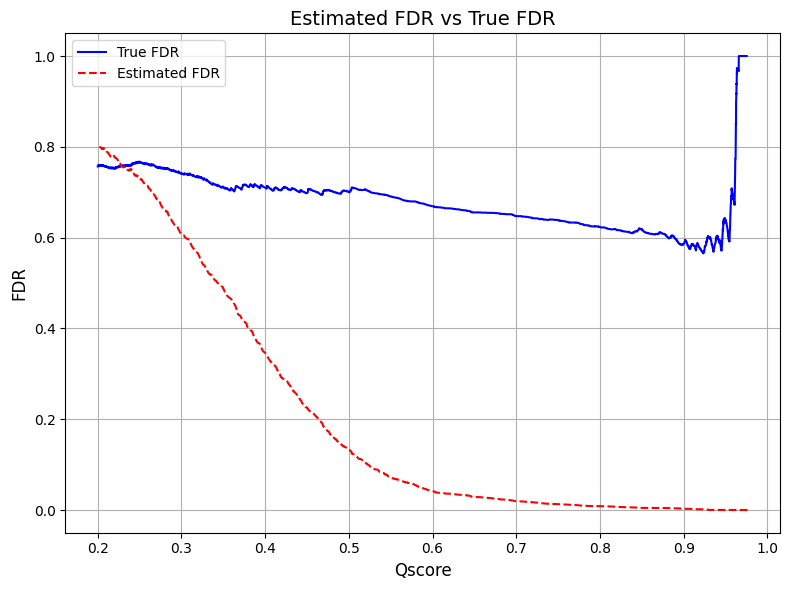

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (replace with your actual file paths)
combined_path = '/content/mergedfile_ms1.tsv'
original_path = 'chosen.csv'

combined_df = pd.read_csv(combined_path, sep='\t')
original_df = pd.read_csv(original_path)

# Define ppm tolerance
ppmtol = 10

# Extract ScanNum and MonoisotopicMass from combined_df
fdval = combined_df[['ScanNum', 'MonoisotopicMass']]
fdval['ScanNum'] = fdval['ScanNum'].astype(int)

# Identify true positives based on ScanNum matching
tpindex1 = fdval['ScanNum'].isin(original_df['ScanNum'].dropna().replace([np.inf, -np.inf], np.nan).astype(int))

# Allow for ±1 Da error with 0.1 Da tolerance
tpindex2 = np.logical_or.reduce([
    (fdval.iloc[:, 1].values[:, np.newaxis] >= original_df.iloc[:, 2].values - 0.1) &
    (fdval.iloc[:, 1].values[:, np.newaxis] <= original_df.iloc[:, 2].values + 0.1),
    (fdval.iloc[:, 1].values[:, np.newaxis] >= original_df.iloc[:, 2].values - 1.1) &
    (fdval.iloc[:, 1].values[:, np.newaxis] <= original_df.iloc[:, 2].values - 0.9),
    (fdval.iloc[:, 1].values[:, np.newaxis] >= original_df.iloc[:, 2].values + 0.9) &
    (fdval.iloc[:, 1].values[:, np.newaxis] <= original_df.iloc[:, 2].values + 1.1)
])

# Final true positive index
tpindex = np.logical_and.reduce((
    tpindex1.values.flatten(),
    tpindex2.any(axis=1),
    combined_df['TargetDecoyType'].values == 0
))

# Identify false positives and decoys
fpindex = np.logical_and.reduce((
    np.logical_not(tpindex),
    combined_df['TargetDecoyType'].values == 0
))
decoyindex = combined_df['TargetDecoyType'] > 0

# Sort data by Qscore
combined_df_sorted = combined_df.sort_values('Qscore', ascending=False)

# Compute cumulative targets and decoys
combined_df_sorted['cumulative_targets'] = np.cumsum(combined_df_sorted['TargetDecoyType'] == 0)
combined_df_sorted['cumulative_decoys'] = np.cumsum(combined_df_sorted['TargetDecoyType'] > 0)

# Compute True FDR based on False Positives and True Positives
combined_df_sorted['true_FDR'] = np.cumsum(fpindex) / (np.cumsum(tpindex) + np.cumsum(fpindex))

# Compute Estimated FDR (using Decoy masses as a proxy for False Positives)
combined_df_sorted['estimated_FDR'] = combined_df_sorted['cumulative_decoys'] / combined_df_sorted['cumulative_targets']

# Apply rolling mean smoothing to Estimated FDR
window_size = 30  # Adjust as needed
combined_df_sorted['estimated_FDR'] = combined_df_sorted['estimated_FDR'].rolling(window=window_size, min_periods=1).mean()

# Plot Actual FDR vs Estimated FDR
plt.figure(figsize=(8,6))
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['true_FDR'], color='blue', label='True FDR')
plt.plot(combined_df_sorted['Qscore'], combined_df_sorted['estimated_FDR'], color='red', linestyle='--', label='Estimated FDR')

plt.xlabel('Qscore', fontsize=12)
plt.ylabel('FDR', fontsize=12)
plt.title('Estimated FDR vs True FDR', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-9-5b9970766caf>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdval['ScanNum'] = fdval['ScanNum'] + 1  # MATLAB indexing starts from 1


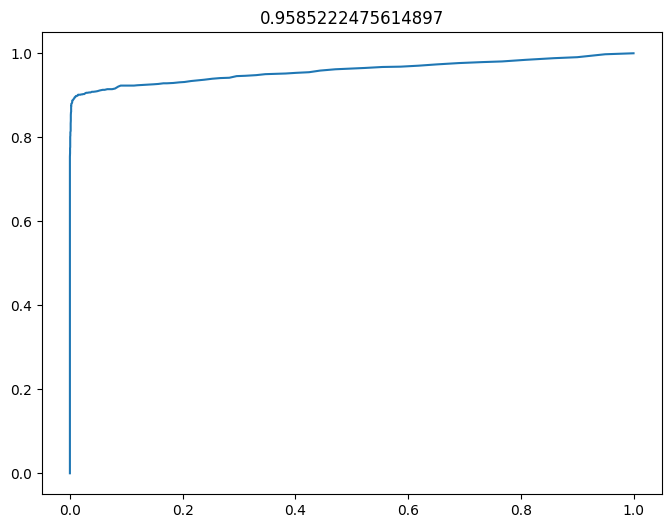

ValueError: 'northwest' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

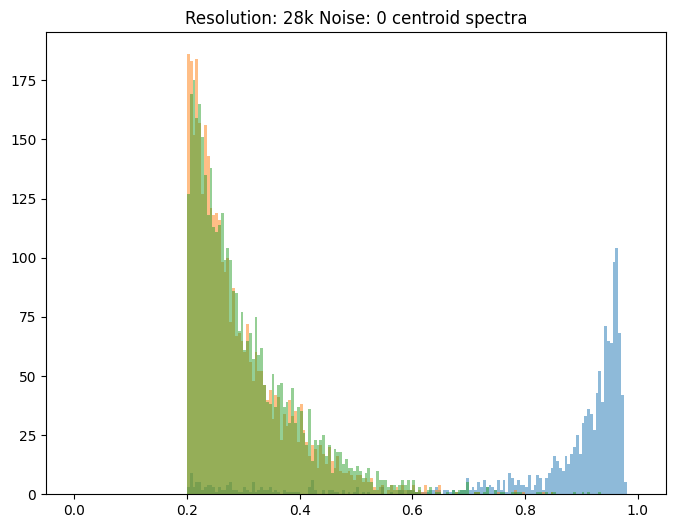

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data (replace with your actual file paths)
combined_path = '/content/mergedfile_ms1.tsv'
original_path = '/content/chosen.csv'

# Load .tsv file
combined_df = pd.read_csv(combined_path, sep='\t')

# Load .csv file
original_df = pd.read_csv(original_path)

# Define constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# Extract ScanNum and MonoisotopicMass from combined_df
fdval = combined_df[['ScanNum', 'MonoisotopicMass']]
fdval['ScanNum'] = fdval['ScanNum'] + 1  # MATLAB indexing starts from 1

# Convert original_df to numpy array for processing
trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Identify true positives
tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) / np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
tpindex2 = tpindex2 & (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

if iso > 0:
    for i in range(1, iso+1):
        tpindex2 = tpindex2 | (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass - trueset[:, 1]) / np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
        tpindex2 = tpindex2 | (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass - trueset[:, 1]) / np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
decoyindex = combined_df['TargetDecoyType'] > 0

# Plot ROC curve
fps = [1]
tps = [1]
auc = 0
for q in np.arange(0, 1.005, 0.005):
    fp = np.sum(combined_df['Qscore2D'][fpindex] > q) / len(combined_df['Qscore2D'][fpindex])
    tp = np.sum(combined_df['Qscore2D'][tpindex] > q) / len(combined_df['Qscore2D'][tpindex])
    auc += (fps[-1] - fp) * (tp + tps[-1]) / 2
    fps.append(fp)
    tps.append(tp)

plt.figure(figsize=(8, 6))
plt.plot(fps, tps)
plt.title(str(auc))
plt.grid(False)
plt.show()

# Histograms
plt.figure(figsize=(8, 6))
plt.hist(combined_df['Qscore2D'][tpindex], bins=np.arange(0, 1.005, 0.005), histtype='bar', label='#true positives', alpha=0.5)
plt.hist(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005), histtype='bar', label='#false positives', alpha=0.5)
plt.hist(combined_df['Qscore2D'][decoyindex], bins=np.arange(0, 1.005, 0.005), histtype='bar', label='#decoy masses', alpha=0.5)

plt.title(f'Resolution: 28k Noise: 0 centroid spectra')
plt.legend(loc='northwest')
plt.xlabel('Qscore2D')
plt.ylabel('Count')
plt.xlim([0, 1])
plt.grid(False)
plt.show()

# More detailed plots
plt.figure(figsize=(8, 6))
fp_hist = plt.hist(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005), alpha=0.5)
dp_hist = plt.hist(combined_df['Qscore2D'][~decoyindex], bins=np.arange(0, 1.005, 0.005), alpha=0.5)

fpv = fp_hist[0]
dpv = dp_hist[0]

cdpv = np.cumsum(dpv[::-1])[::-1]
cfpv = np.cumsum(fpv[::-1])[::-1]

fdr = cfpv / (cdpv + np.finfo(float).eps)
minfdr = 1
for i in range(len(fdr)):
    fdr[i] = min(minfdr, fdr[i])
    minfdr = fdr[i]

bin_centers = (dp_hist[1][1:] + dp_hist[1][:-1]) / 2
plt.plot(bin_centers, fdr, 'b-', linewidth=1)

plt.title(f'Resolution: 28k Noise: 0 centroid spectra')
plt.xlabel('Qscore2D')
plt.ylabel('qvalue or FDR')
plt.legend(['True FDR'])

tmp = combined_df[['Qscore2D', 'Qvalue']][combined_df['TargetDecoyType'] == 0].sort_values('Qscore2D').values
plt.plot(tmp[:, 0], tmp[:, 1], '--', linewidth=1)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.grid(False)
plt.show()

<ipython-input-14-0d550900039d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdval['ScanNum'] = fdval['ScanNum'] + 1  # MATLAB indexing starts from 1


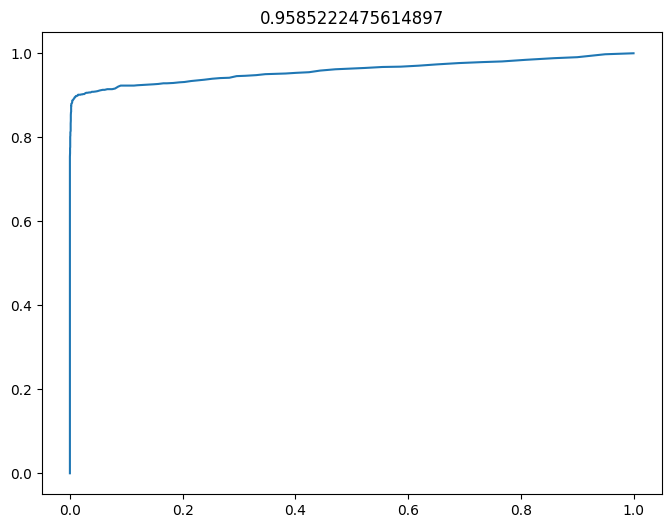

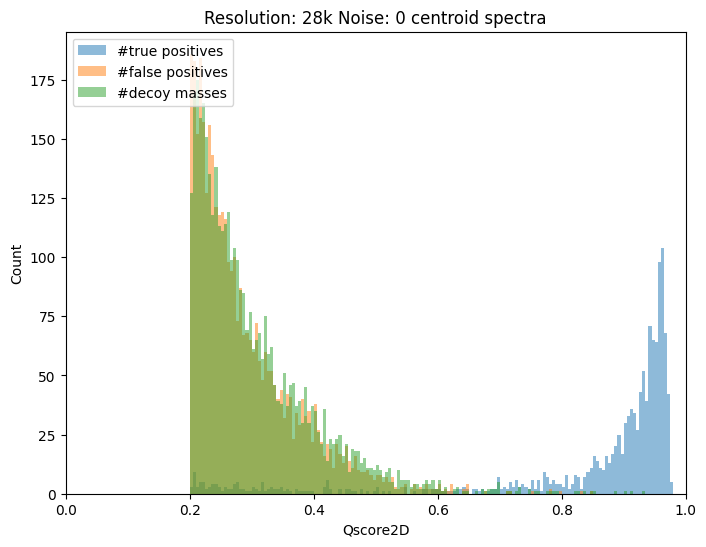

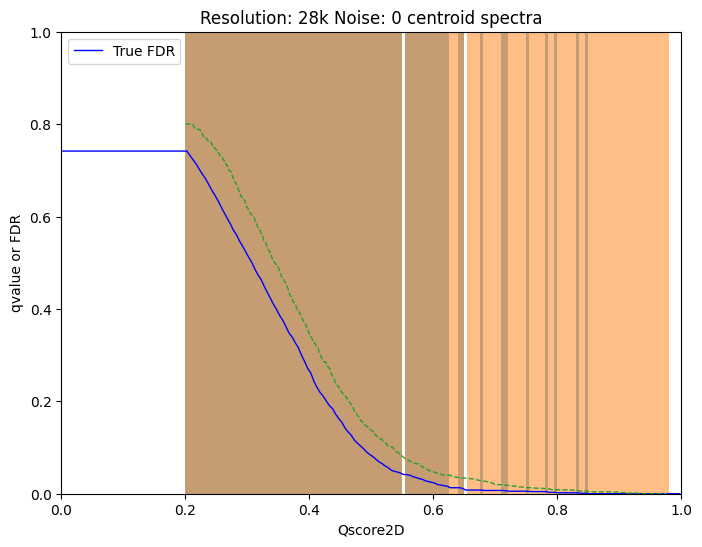

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data (replace with your actual file paths)
combined_path = '/content/mergedfile_ms1.tsv'
original_path = '/content/chosen.csv'

# Load .tsv file
combined_df = pd.read_csv(combined_path, sep='\t')

# Load .csv file
original_df = pd.read_csv(original_path)

# Define constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# Extract ScanNum and MonoisotopicMass from combined_df
fdval = combined_df[['ScanNum', 'MonoisotopicMass']]
fdval['ScanNum'] = fdval['ScanNum'] + 1  # MATLAB indexing starts from 1

# Convert original_df to numpy array for processing
trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Identify true positives
tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) / np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
tpindex2 = tpindex2 & (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

if iso > 0:
    for i in range(1, iso+1):
        tpindex2 = tpindex2 | (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass - trueset[:, 1]) / np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
        tpindex2 = tpindex2 | (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass - trueset[:, 1]) / np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
decoyindex = combined_df['TargetDecoyType'] > 0

# Plot ROC curve
fps = [1]
tps = [1]
auc = 0
for q in np.arange(0, 1.005, 0.005):
    fp = np.sum(combined_df['Qscore2D'][fpindex] > q) / len(combined_df['Qscore2D'][fpindex])
    tp = np.sum(combined_df['Qscore2D'][tpindex] > q) / len(combined_df['Qscore2D'][tpindex])
    auc += (fps[-1] - fp) * (tp + tps[-1]) / 2
    fps.append(fp)
    tps.append(tp)

plt.figure(figsize=(8, 6))
plt.plot(fps, tps)
plt.title(str(auc))
plt.grid(False)
plt.show()

# Histograms
plt.figure(figsize=(8, 6))
plt.hist(combined_df['Qscore2D'][tpindex], bins=np.arange(0, 1.005, 0.005), histtype='bar', label='#true positives', alpha=0.5)
plt.hist(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005), histtype='bar', label='#false positives', alpha=0.5)
plt.hist(combined_df['Qscore2D'][decoyindex], bins=np.arange(0, 1.005, 0.005), histtype='bar', label='#decoy masses', alpha=0.5)


plt.title(f'Resolution: 28k Noise: 0 centroid spectra')
plt.legend(loc='upper left')
plt.xlabel('Qscore2D')
plt.ylabel('Count')
plt.xlim([0, 1])
plt.grid(False)
plt.show()

# More detailed plots
plt.figure(figsize=(8, 6))
fp_hist = plt.hist(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005), alpha=0.5)
dp_hist = plt.hist(combined_df['Qscore2D'][~decoyindex], bins=np.arange(0, 1.005, 0.005), alpha=0.5)

fpv = fp_hist[0]
dpv = dp_hist[0]

cdpv = np.cumsum(dpv[::-1])[::-1]
cfpv = np.cumsum(fpv[::-1])[::-1]

fdr = cfpv / (cdpv + np.finfo(float).eps)
minfdr = 1
for i in range(len(fdr)):
    fdr[i] = min(minfdr, fdr[i])
    minfdr = fdr[i]

bin_centers = (dp_hist[1][1:] + dp_hist[1][:-1]) / 2
plt.plot(bin_centers, fdr, 'b-', linewidth=1)

plt.title(f'Resolution: 28k Noise: 0 centroid spectra')
plt.xlabel('Qscore2D')
plt.ylabel('qvalue or FDR')
plt.legend(['True FDR'])

tmp = combined_df[['Qscore2D', 'Qvalue']][combined_df['TargetDecoyType'] == 0].sort_values('Qscore2D').values
plt.plot(tmp[:, 0], tmp[:, 1], '--', linewidth=1)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.grid(False)
plt.show()

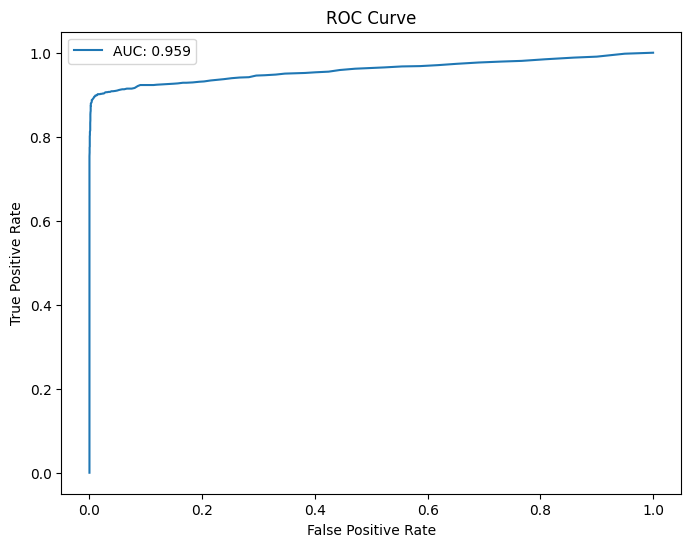

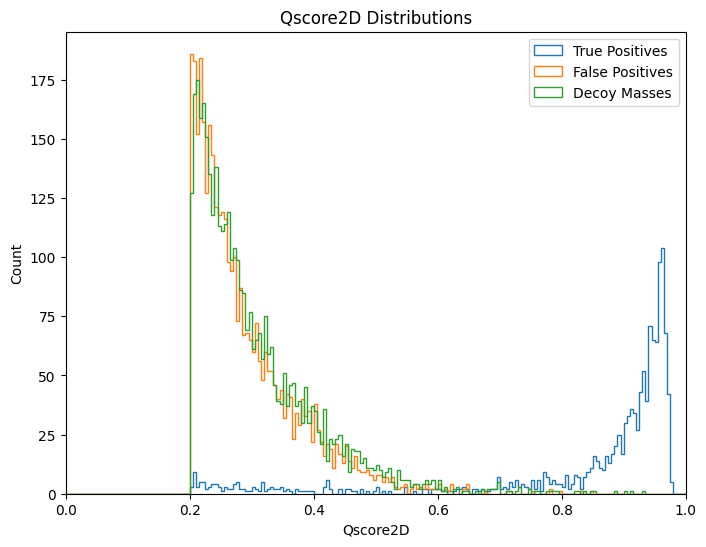

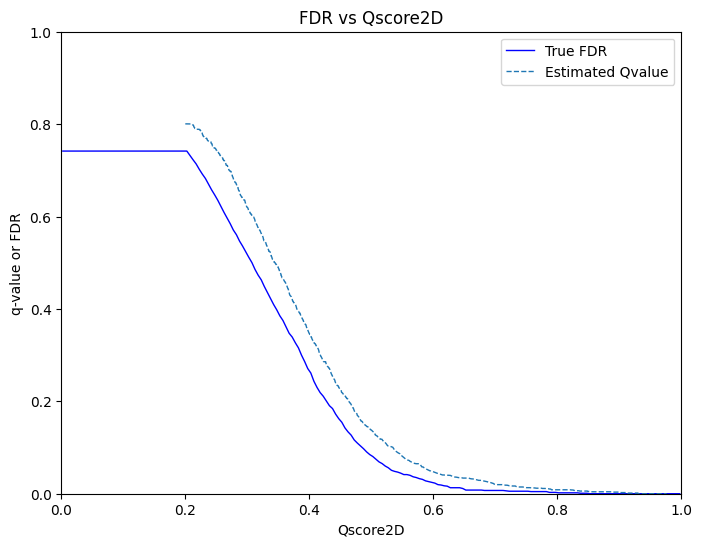

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
combined_path = '/content/mergedfile_ms1.tsv'
original_path = '/content/chosen.csv'
combined_df = pd.read_csv(combined_path, sep='\t')
original_df = pd.read_csv(original_path)

# Define constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# Process scan numbers
fdval = combined_df[['ScanNum', 'MonoisotopicMass']].copy()
fdval['ScanNum'] += 1  # Adjust for MATLAB indexing

trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Identify true positives
tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) /
                  np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
tpindex2 &= (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

if iso > 0:
    for i in range(1, iso + 1):
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
decoyindex = combined_df['TargetDecoyType'] > 0

# Plot ROC curve
fps, tps, auc = [1], [1], 0
for q in np.arange(0, 1.005, 0.005):
    fp = np.sum(combined_df['Qscore2D'][fpindex] > q) / len(combined_df['Qscore2D'][fpindex])
    tp = np.sum(combined_df['Qscore2D'][tpindex] > q) / len(combined_df['Qscore2D'][tpindex])
    auc += (fps[-1] - fp) * (tp + tps[-1]) / 2
    fps.append(fp)
    tps.append(tp)

plt.figure(figsize=(8, 6))
plt.plot(fps, tps, label=f'AUC: {auc:.3f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(False)
plt.show()

# Histograms
plt.figure(figsize=(8, 6))
plt.hist(combined_df['Qscore2D'][tpindex], bins=np.arange(0, 1.005, 0.005), histtype='step', label='True Positives')
plt.hist(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005), histtype='step', label='False Positives')
plt.hist(combined_df['Qscore2D'][decoyindex], bins=np.arange(0, 1.005, 0.005), histtype='step', label='Decoy Masses')
plt.title('Qscore2D Distributions')
plt.xlabel('Qscore2D')
plt.ylabel('Count')
plt.legend()
plt.xlim([0, 1])
plt.grid(False)
plt.show()

# FDR Plot
plt.figure(figsize=(8, 6))
fp_hist = np.histogram(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005))
dp_hist = np.histogram(combined_df['Qscore2D'][~decoyindex], bins=np.arange(0, 1.005, 0.005))

fpv, dpv = fp_hist[0], dp_hist[0]
cdpv = np.cumsum(dpv[::-1])[::-1]
cfpv = np.cumsum(fpv[::-1])[::-1]
fdr = cfpv / (cdpv + np.finfo(float).eps)

# Ensure monotonic decreasing FDR
minfdr = 1
for i in range(len(fdr)):
    fdr[i] = min(minfdr, fdr[i])
    minfdr = fdr[i]

bin_centers = (dp_hist[1][1:] + dp_hist[1][:-1]) / 2
plt.plot(bin_centers, fdr, 'b-', linewidth=1, label='True FDR')

# Overlay Qvalue
tmp = combined_df[['Qscore2D', 'Qvalue']][combined_df['TargetDecoyType'] == 0].sort_values('Qscore2D').values
plt.plot(tmp[:, 0], tmp[:, 1], '--', linewidth=1, label='Estimated Qvalue')

plt.title('FDR vs Qscore2D')
plt.xlabel('Qscore2D')
plt.ylabel('q-value or FDR')
plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.grid(False)
plt.show()


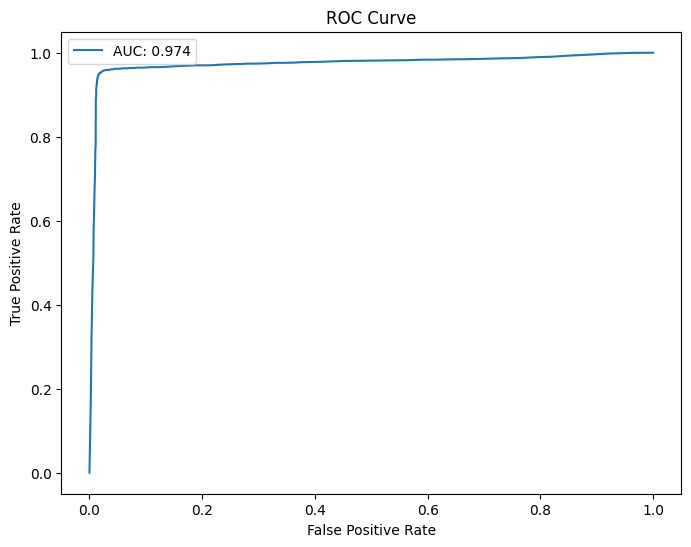

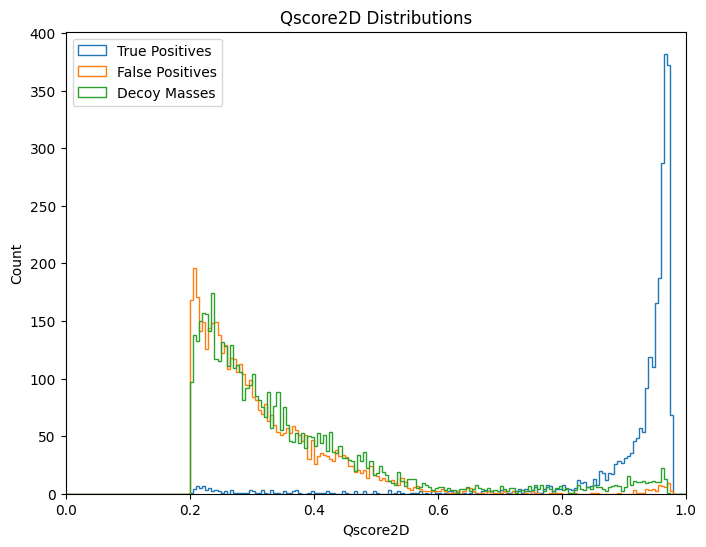

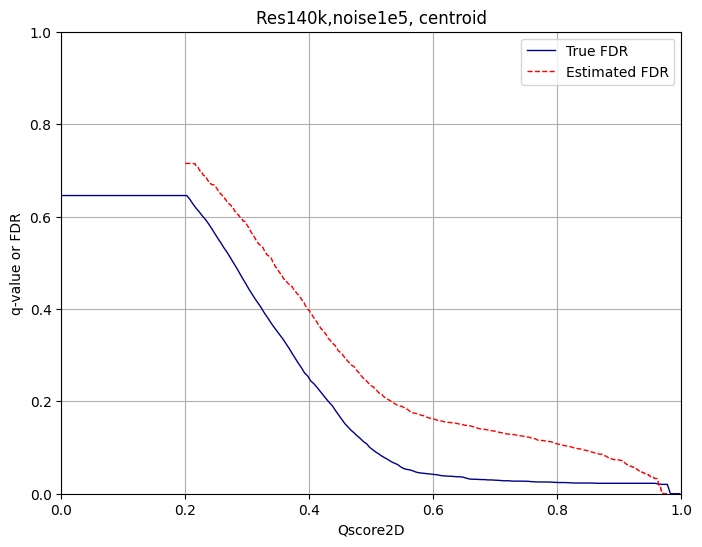

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
combined_path = '/content/res140k_noise1e5.tsv'
original_path = '/content/chosen.csv'
combined_df = pd.read_csv(combined_path, sep='\t')
original_df = pd.read_csv(original_path)

# Define constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# Process scan numbers
fdval = combined_df[['ScanNum', 'MonoisotopicMass']].copy()
fdval['ScanNum'] += 1  # Adjust for MATLAB indexing

trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Identify true positives
tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) /
                  np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
tpindex2 &= (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

if iso > 0:
    for i in range(1, iso + 1):
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
decoyindex = combined_df['TargetDecoyType'] > 0

# Plot ROC curve
fps, tps, auc = [1], [1], 0
for q in np.arange(0, 1.005, 0.005):
    fp = np.sum(combined_df['Qscore2D'][fpindex] > q) / len(combined_df['Qscore2D'][fpindex])
    tp = np.sum(combined_df['Qscore2D'][tpindex] > q) / len(combined_df['Qscore2D'][tpindex])
    auc += (fps[-1] - fp) * (tp + tps[-1]) / 2
    fps.append(fp)
    tps.append(tp)

plt.figure(figsize=(8, 6))
plt.plot(fps, tps, label=f'AUC: {auc:.3f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(False)
plt.show()

# Histograms
plt.figure(figsize=(8, 6))
plt.hist(combined_df['Qscore2D'][tpindex], bins=np.arange(0, 1.005, 0.005), histtype='step', label='True Positives')
plt.hist(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005), histtype='step', label='False Positives')
plt.hist(combined_df['Qscore2D'][decoyindex], bins=np.arange(0, 1.005, 0.005), histtype='step', label='Decoy Masses')
plt.title('Qscore2D Distributions')
plt.xlabel('Qscore2D')
plt.ylabel('Count')
plt.legend()
plt.xlim([0, 1])
plt.grid(False)
plt.show()

# FDR Plot
plt.figure(figsize=(8, 6))
fp_hist = np.histogram(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005))
dp_hist = np.histogram(combined_df['Qscore2D'][~decoyindex], bins=np.arange(0, 1.005, 0.005))

fpv, dpv = fp_hist[0], dp_hist[0]
cdpv = np.cumsum(dpv[::-1])[::-1]
cfpv = np.cumsum(fpv[::-1])[::-1]
fdr = cfpv / (cdpv + np.finfo(float).eps)

# Ensure monotonic decreasing FDR
minfdr = 1
for i in range(len(fdr)):
    fdr[i] = min(minfdr, fdr[i])
    minfdr = fdr[i]

bin_centers = (dp_hist[1][1:] + dp_hist[1][:-1]) / 2
plt.plot(bin_centers, fdr, 'darkblue', linewidth=1, label='True FDR')  # Dark blue for true FDR

# Overlay Qvalue with red dashed line
tmp = combined_df[['Qscore2D', 'Qvalue']][combined_df['TargetDecoyType'] == 0].sort_values('Qscore2D').values
plt.plot(tmp[:, 0], tmp[:, 1], 'red', linestyle='--', linewidth=1, label='Estimated FDR')  # Red dashed line for estimated FDR

plt.title('Res140k,noise1e5, centroid')
plt.xlabel('Qscore2D')
plt.ylabel('q-value or FDR')
plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.grid(True)
plt.show()




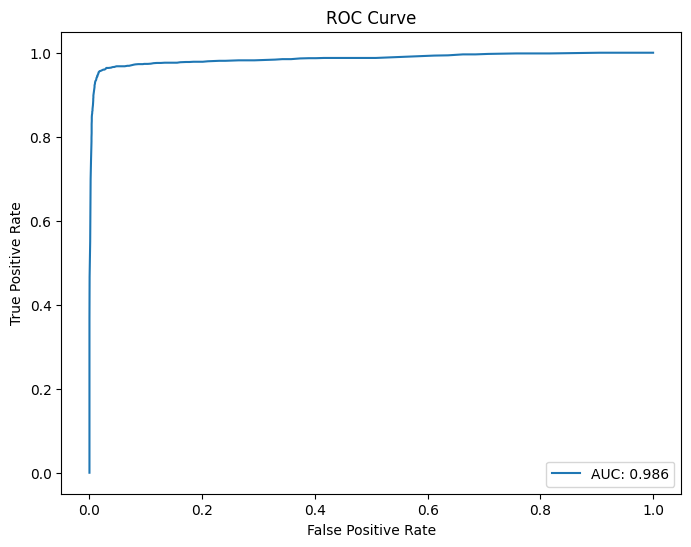

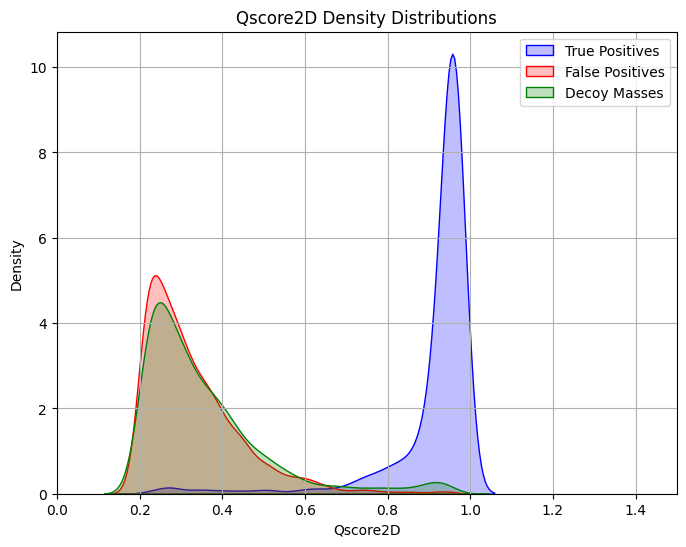

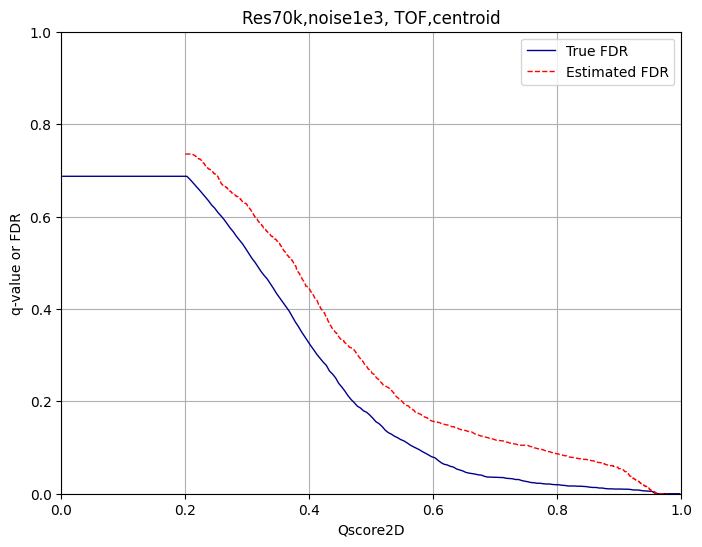

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
combined_path = '/content/mergedfile_res70k_noise1e3_ms1.tsv'
original_path = '/content/chosen.csv'
combined_df = pd.read_csv(combined_path, sep='\t')
original_df = pd.read_csv(original_path)

# Define constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# Process scan numbers
fdval = combined_df[['ScanNum', 'MonoisotopicMass']].copy()
fdval['ScanNum'] += 1  # Adjust for MATLAB indexing

trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Identify true positives
tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) /
                  np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
tpindex2 &= (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

if iso > 0:
    for i in range(1, iso + 1):
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
decoyindex = combined_df['TargetDecoyType'] > 0

# Plot ROC curve
fps, tps, auc = [1], [1], 0
for q in np.arange(0, 1.005, 0.005):
    fp = np.sum(combined_df['Qscore2D'][fpindex] > q) / len(combined_df['Qscore2D'][fpindex])
    tp = np.sum(combined_df['Qscore2D'][tpindex] > q) / len(combined_df['Qscore2D'][tpindex])
    auc += (fps[-1] - fp) * (tp + tps[-1]) / 2
    fps.append(fp)
    tps.append(tp)

plt.figure(figsize=(8, 6))
plt.plot(fps, tps, label=f'AUC: {auc:.3f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(False)
plt.show()

# Density Plot for Qscore2D distributions
plt.figure(figsize=(8, 6))

sns.kdeplot(combined_df['Qscore2D'][tpindex], label='True Positives', color='blue', fill=True)
sns.kdeplot(combined_df['Qscore2D'][fpindex], label='False Positives', color='red', fill=True)
sns.kdeplot(combined_df['Qscore2D'][decoyindex], label='Decoy Masses', color='green', fill=True)

plt.title('Qscore2D Density Distributions')
plt.xlabel('Qscore2D')
plt.ylabel('Density')
plt.legend()
plt.xlim([0, 1.5])
plt.grid(True)
plt.show()

# FDR Plot
plt.figure(figsize=(8, 6))
fp_hist = np.histogram(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005))
dp_hist = np.histogram(combined_df['Qscore2D'][~decoyindex], bins=np.arange(0, 1.005, 0.005))

fpv, dpv = fp_hist[0], dp_hist[0]
cdpv = np.cumsum(dpv[::-1])[::-1]
cfpv = np.cumsum(fpv[::-1])[::-1]
fdr = cfpv / (cdpv + np.finfo(float).eps)

# Ensure monotonic decreasing FDR
minfdr = 1
for i in range(len(fdr)):
    fdr[i] = min(minfdr, fdr[i])
    minfdr = fdr[i]

bin_centers = (dp_hist[1][1:] + dp_hist[1][:-1]) / 2
plt.plot(bin_centers, fdr, 'darkblue', linewidth=1, label='True FDR')  # Dark blue for true FDR

# Overlay Qvalue with red dashed line
tmp = combined_df[['Qscore2D', 'Qvalue']][combined_df['TargetDecoyType'] == 0].sort_values('Qscore2D').values
plt.plot(tmp[:, 0], tmp[:, 1], 'red', linestyle='--', linewidth=1, label='Estimated FDR')  # Red dashed line for estimated FDR

plt.title('Res70k,noise1e3, TOF,centroid')
plt.xlabel('Qscore2D')
plt.ylabel('q-value or FDR')
plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.grid(True)
plt.show()


Length of true_fdr_interp: 6361
Length of estimated_fdr: 6361
MAE: 0.0532
RMSE: 0.0613
Pearson Correlation: 0.9954


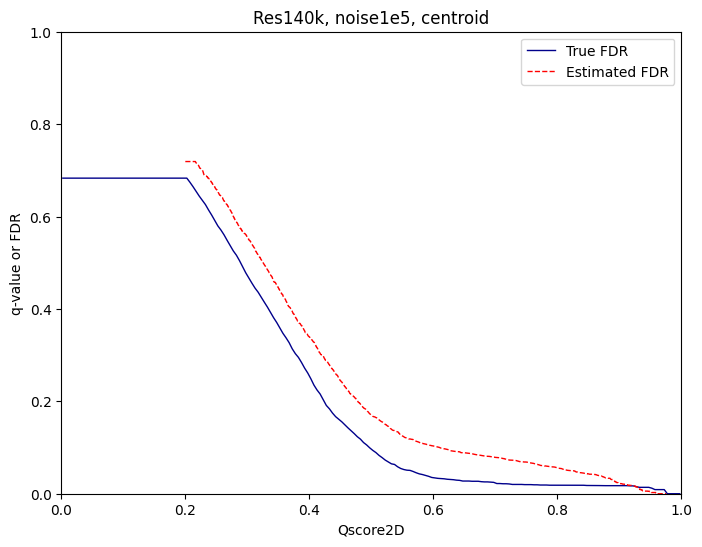

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the data
combined_path = '/content/res70k_noise1e5.tsv'
original_path = '/content/chosen.csv'
combined_df = pd.read_csv(combined_path, sep='\t')
original_df = pd.read_csv(original_path)



# Define constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# Process scan numbers
fdval = combined_df[['ScanNum', 'MonoisotopicMass']].copy()
fdval['ScanNum'] += 1  # Adjust for MATLAB indexing

trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Identify true positives
tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) /
                  np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
tpindex2 &= (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

if iso > 0:
    for i in range(1, iso + 1):
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
decoyindex = combined_df['TargetDecoyType'] > 0

# Compute histogram-based FDR
fp_hist = np.histogram(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005))
dp_hist = np.histogram(combined_df['Qscore2D'][~decoyindex], bins=np.arange(0, 1.005, 0.005))

fpv, dpv = fp_hist[0], dp_hist[0]
cdpv = np.cumsum(dpv[::-1])[::-1]
cfpv = np.cumsum(fpv[::-1])[::-1]
true_fdr = cfpv / (cdpv + np.finfo(float).eps)

# Ensure monotonic decreasing FDR
minfdr = 1
for i in range(len(true_fdr)):
    true_fdr[i] = min(minfdr, true_fdr[i])
    minfdr = true_fdr[i]

# Extract estimated FDR
tmp = combined_df[['Qscore2D', 'Qvalue']][combined_df['TargetDecoyType'] == 0].sort_values('Qscore2D').values
qscore_values = tmp[:, 0]
estimated_fdr = tmp[:, 1]

# Interpolate true_fdr to match qscore_values
bin_centers = (dp_hist[1][1:] + dp_hist[1][:-1]) / 2
true_fdr_interp = np.interp(qscore_values, bin_centers, true_fdr)

# Ensure lengths match
print(f"Length of true_fdr_interp: {len(true_fdr_interp)}")
print(f"Length of estimated_fdr: {len(estimated_fdr)}")

# Compute accuracy metrics
mae = mean_absolute_error(true_fdr_interp, estimated_fdr)
rmse = np.sqrt(mean_squared_error(true_fdr_interp, estimated_fdr))
r_value, _ = pearsonr(true_fdr_interp, estimated_fdr)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Pearson Correlation: {r_value:.4f}")

# FDR Plot
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, true_fdr, 'darkblue', linewidth=1, label='True FDR')  # Dark blue for true FDR
plt.plot(qscore_values, estimated_fdr, 'red', linestyle='--', linewidth=1, label='Estimated FDR')  # Red dashed line for estimated FDR

plt.title('Res140k, noise1e5, centroid')
plt.xlabel('Qscore2D')
plt.ylabel('q-value or FDR')
plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.grid(False)
plt.show()




<ipython-input-2-71dd4dee7be7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdval['ScanNum'] += 1  # Adjust for MATLAB indexing


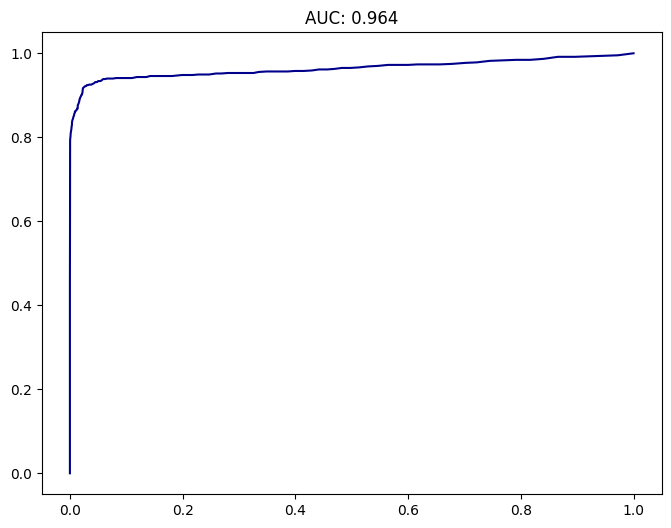

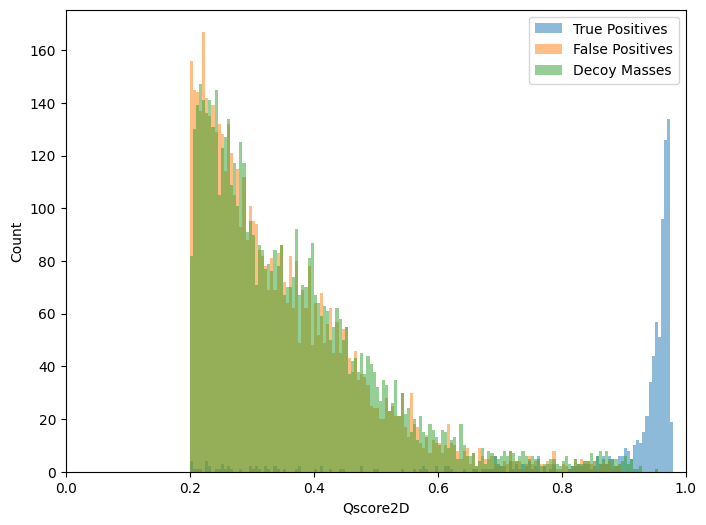

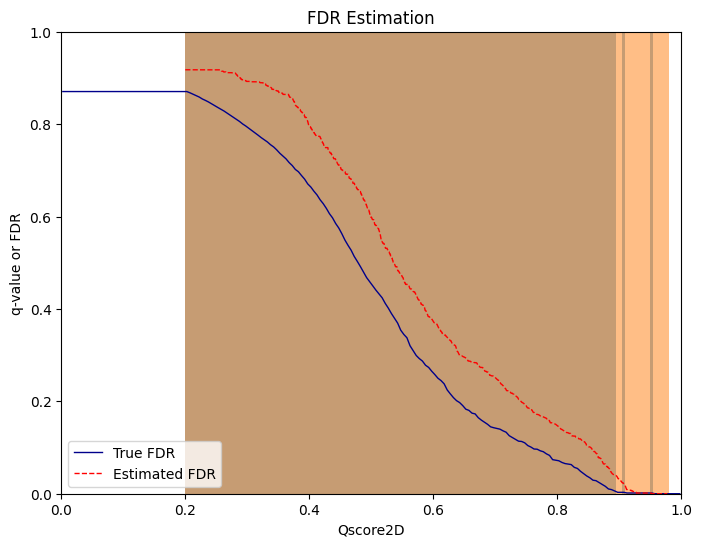

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
combined_path = '/content/mergedfile_res30k_noise1e3_ms1.tsv'
original_path = '/content/chosen.csv'

combined_df = pd.read_csv(combined_path, sep='\t')
original_df = pd.read_csv(original_path)

# Constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# Prepare data
fdval = combined_df[['ScanNum', 'MonoisotopicMass']]
fdval['ScanNum'] += 1  # Adjust for MATLAB indexing
trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Identify true positives
tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) /
                  np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
tpindex2 &= np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0

for i in range(1, iso+1):
    tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass - trueset[:, 1]) /
                        np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
    tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass - trueset[:, 1]) /
                        np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
decoyindex = combined_df['TargetDecoyType'] > 0

# ROC Curve
fps, tps, auc = [1], [1], 0
for q in np.arange(0, 1.005, 0.005):
    fp = np.sum(combined_df['Qscore2D'][fpindex] > q) / len(combined_df['Qscore2D'][fpindex])
    tp = np.sum(combined_df['Qscore2D'][tpindex] > q) / len(combined_df['Qscore2D'][tpindex])
    auc += (fps[-1] - fp) * (tp + tps[-1]) / 2
    fps.append(fp)
    tps.append(tp)

plt.figure(figsize=(8, 6))
plt.plot(fps, tps, color='darkblue')
plt.title(f'AUC: {auc:.3f}')
plt.grid(False)
plt.show()

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(combined_df['Qscore2D'][tpindex], bins=np.arange(0, 1.005, 0.005), alpha=0.5, label='True Positives')
plt.hist(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005), alpha=0.5, label='False Positives')
plt.hist(combined_df['Qscore2D'][decoyindex], bins=np.arange(0, 1.005, 0.005), alpha=0.5, label='Decoy Masses')
plt.legend()
plt.xlabel('Qscore2D')
plt.ylabel('Count')
plt.xlim([0, 1])
plt.grid(False)
plt.show()

# FDR Plot
plt.figure(figsize=(8, 6))
fp_hist = plt.hist(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005), alpha=0.5)
dp_hist = plt.hist(combined_df['Qscore2D'][~decoyindex], bins=np.arange(0, 1.005, 0.005), alpha=0.5)

fpv, dpv = fp_hist[0], dp_hist[0]
cdpv, cfpv = np.cumsum(dpv[::-1])[::-1], np.cumsum(fpv[::-1])[::-1]
fdr = cfpv / (cdpv + np.finfo(float).eps)

minfdr = 1
for i in range(len(fdr)):
    fdr[i] = min(minfdr, fdr[i])
    minfdr = fdr[i]

bin_centers = (dp_hist[1][1:] + dp_hist[1][:-1]) / 2
plt.plot(bin_centers, fdr, color='darkblue', linewidth=1, label='True FDR')

# Estimated FDR in dashed red
tmp = combined_df[['Qscore2D', 'Qvalue']][combined_df['TargetDecoyType'] == 0].sort_values('Qscore2D').values
plt.plot(tmp[:, 0], tmp[:, 1], '--', color='red', linewidth=1, label='Estimated FDR')

plt.title('FDR Estimation')
plt.xlabel('Qscore2D')
plt.ylabel('q-value or FDR')
plt.legend()
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.grid(False)
plt.show()

In [43]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of paths to the six different files
combined_paths = [
    '/content/res/res35k_noise1e3.tsv',
    #'/content/res/res35k_noise1e5.tsv',
    #'/content/res/res70k_noise1e3.tsv',
    #'/content/res/res70k_noise1e5.tsv',
    #'/content/res/res140k_noise1e3.tsv',
    #'/content/res/res140k_noise1e5.tsv'
]

original_path = '/content/chosen.csv'

# Load the original data
original_df = pd.read_csv(original_path)

# Define constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# Initialize the figure with 2 rows and 3 columns for side-by-side plots
#fig, axes = plt.subplots(2, 3, figsize=(18, 10))
#axes = axes.flatten()  # Flatten to make iteration easier

# Iterate through the paths of combined files
for i, combined_path in enumerate(combined_paths):
    # Check file existence
    if not os.path.exists(combined_path):
        print(f"File not found: {combined_path}")
        continue  # Skip to the next file if not found

    # Load data
    combined_df = pd.read_csv(combined_path, sep='\t')

    # Validate data in dataframe
    if combined_df.empty or 'Qscore2D' not in combined_df.columns or 'TargetDecoyType' not in combined_df.columns:
        print(f"Skipping {combined_path} due to missing or invalid data")
        continue  # Skip plotting if data is invalid or missing

    # ... (rest of the code within the loop remains the same)

File: /content/mergedfile_ms1.tsv
True Positives: 1414
False Positives: 10739
Decoy Masses: 11156


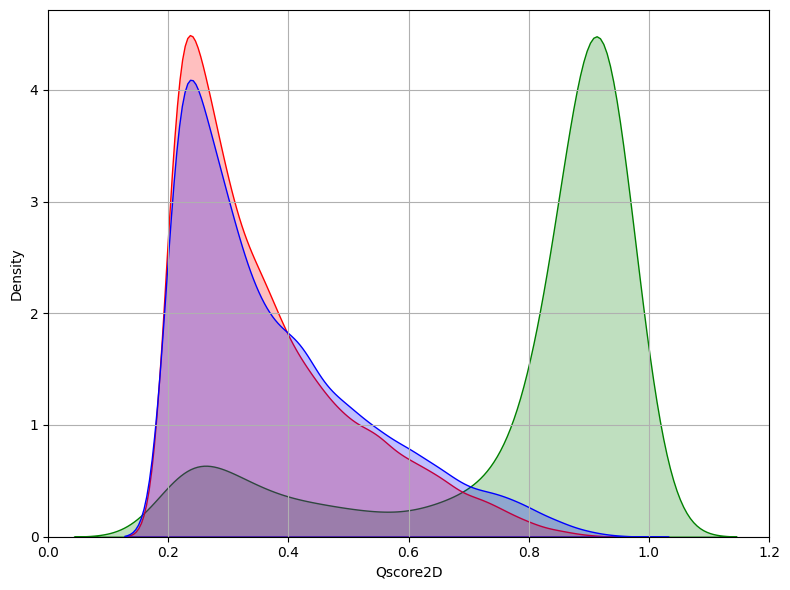

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path to the single file you want to analyze
file_path = '/content/mergedfile_ms1.tsv'
original_path = '/content/chosen.csv'

# Load the original data
original_df = pd.read_csv(original_path)

# Define constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# Load the current combined file
combined_df = pd.read_csv(file_path, sep='\t')

# Process scan numbers
fdval = combined_df[['ScanNum', 'MonoisotopicMass']].copy()
fdval['ScanNum'] += 1  # Adjust for MATLAB indexing

trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Identify true positives
tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) /
                  np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
tpindex2 &= (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

if iso > 0:
    for iso_shift in range(1, iso + 1):
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + iso_shift * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + iso_shift * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - iso_shift * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - iso_shift * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
decoyindex = combined_df['TargetDecoyType'] > 0

# Debugging: Print the sizes of the categories
print(f"File: {file_path}")
print(f"True Positives: {np.sum(tpindex)}")
print(f"False Positives: {np.sum(fpindex)}")
print(f"Decoy Masses: {np.sum(decoyindex)}")

# Plotting
plt.figure(figsize=(8, 6))
if np.sum(tpindex) > 0:
    sns.kdeplot(combined_df['Qscore2D'][tpindex], label='True Positives', fill=True, color='green')
if np.sum(fpindex) > 0:
    sns.kdeplot(combined_df['Qscore2D'][fpindex], label='False Positives', fill=True, color='red')
if np.sum(decoyindex) > 0:
    sns.kdeplot(combined_df['Qscore2D'][decoyindex], label='Decoy Masses', fill=True, color='blue')

#plt.title(f'Qscore2D Density for {file_path.split("/")[-1]}')
#plt.xlabel('Qscore2D')
#plt.ylabel('Density')
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim([0, 1.20])
plt.grid(True)
plt.tight_layout()
plt.show()


Length of true_fdr_interp: 6417
Length of estimated_fdr: 6417
MAE: 0.0921
RMSE: 0.1016
Pearson Correlation: 0.9912


<ipython-input-6-cebb29392532>:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


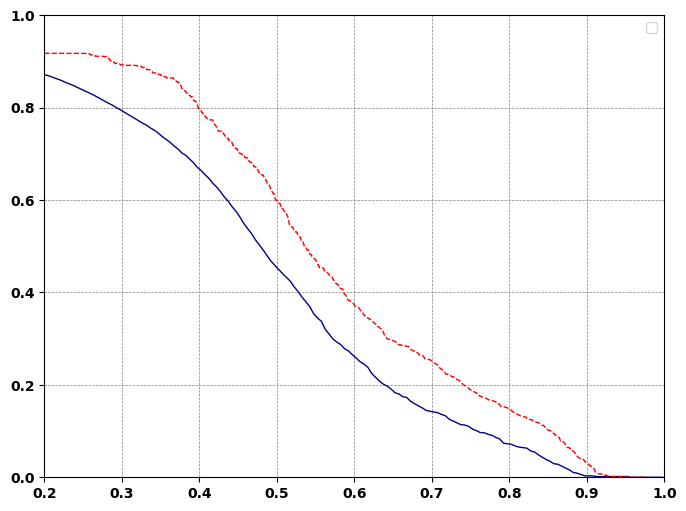

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the data
combined_path = '/content/mergedfile_res30k_noise1e3_ms1.tsv'
original_path = '/content/chosen.csv'
combined_df = pd.read_csv(combined_path, sep='\t')
original_df = pd.read_csv(original_path)

# Define constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# Process scan numbers
fdval = combined_df[['ScanNum', 'MonoisotopicMass']].copy()
fdval['ScanNum'] += 1  # Adjust for MATLAB indexing

trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Identify true positives
tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) /
                  np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
tpindex2 &= (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

if iso > 0:
    for i in range(1, iso + 1):
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
decoyindex = combined_df['TargetDecoyType'] > 0

# Compute histogram-based FDR
fp_hist = np.histogram(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005))
dp_hist = np.histogram(combined_df['Qscore2D'][~decoyindex], bins=np.arange(0, 1.005, 0.005))

fpv, dpv = fp_hist[0], dp_hist[0]
cdpv = np.cumsum(dpv[::-1])[::-1]
cfpv = np.cumsum(fpv[::-1])[::-1]
true_fdr = cfpv / (cdpv + np.finfo(float).eps)

# Ensure monotonic decreasing FDR
minfdr = 1
for i in range(len(true_fdr)):
    true_fdr[i] = min(minfdr, true_fdr[i])
    minfdr = true_fdr[i]

# Extract estimated FDR
tmp = combined_df[['Qscore2D', 'Qvalue']][combined_df['TargetDecoyType'] == 0].sort_values('Qscore2D').values
qscore_values = tmp[:, 0]
estimated_fdr = tmp[:, 1]

# Interpolate true_fdr to match qscore_values
bin_centers = (dp_hist[1][1:] + dp_hist[1][:-1]) / 2
true_fdr_interp = np.interp(qscore_values, bin_centers, true_fdr)

# Ensure lengths match
print(f"Length of true_fdr_interp: {len(true_fdr_interp)}")
print(f"Length of estimated_fdr: {len(estimated_fdr)}")

# Compute accuracy metrics
mae = mean_absolute_error(true_fdr_interp, estimated_fdr)
rmse = np.sqrt(mean_squared_error(true_fdr_interp, estimated_fdr))
r_value, _ = pearsonr(true_fdr_interp, estimated_fdr)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Pearson Correlation: {r_value:.4f}")

# FDR Plot
#plt.figure(figsize=(8, 6))
#plt.plot(bin_centers, true_fdr, 'darkblue', linewidth=1, label='True FDR')  # Dark blue for true FDR
#plt.plot(qscore_values, estimated_fdr, 'red', linestyle='--', linewidth=1, label='Estimated FDR')  # Red dashed line for estimated FDR

# FDR Plot
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, true_fdr, 'darkblue', linewidth=1)  # Dark blue for true FDR
plt.plot(qscore_values, estimated_fdr, 'red', linestyle='--', linewidth=1)  # Red dashed line for estimated FDR

#plt.title('Res140k, noise1e5, centroid')
#plt.xlabel('Qscore2D', fontsize=12, fontweight='bold')
#plt.ylabel('q-value or FDR', fontsize=12, fontweight='bold')

# Make tick labels darker
plt.xticks(fontsize=10, fontweight='bold', color='black')
plt.yticks(fontsize=10, fontweight='bold', color='black')

# Add grid with a light gray color
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

plt.legend()
plt.ylim([0, 1])
plt.xlim([0.2, 1])
plt.show()


<ipython-input-26-d9d7d1d183c8>:80: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.displot(


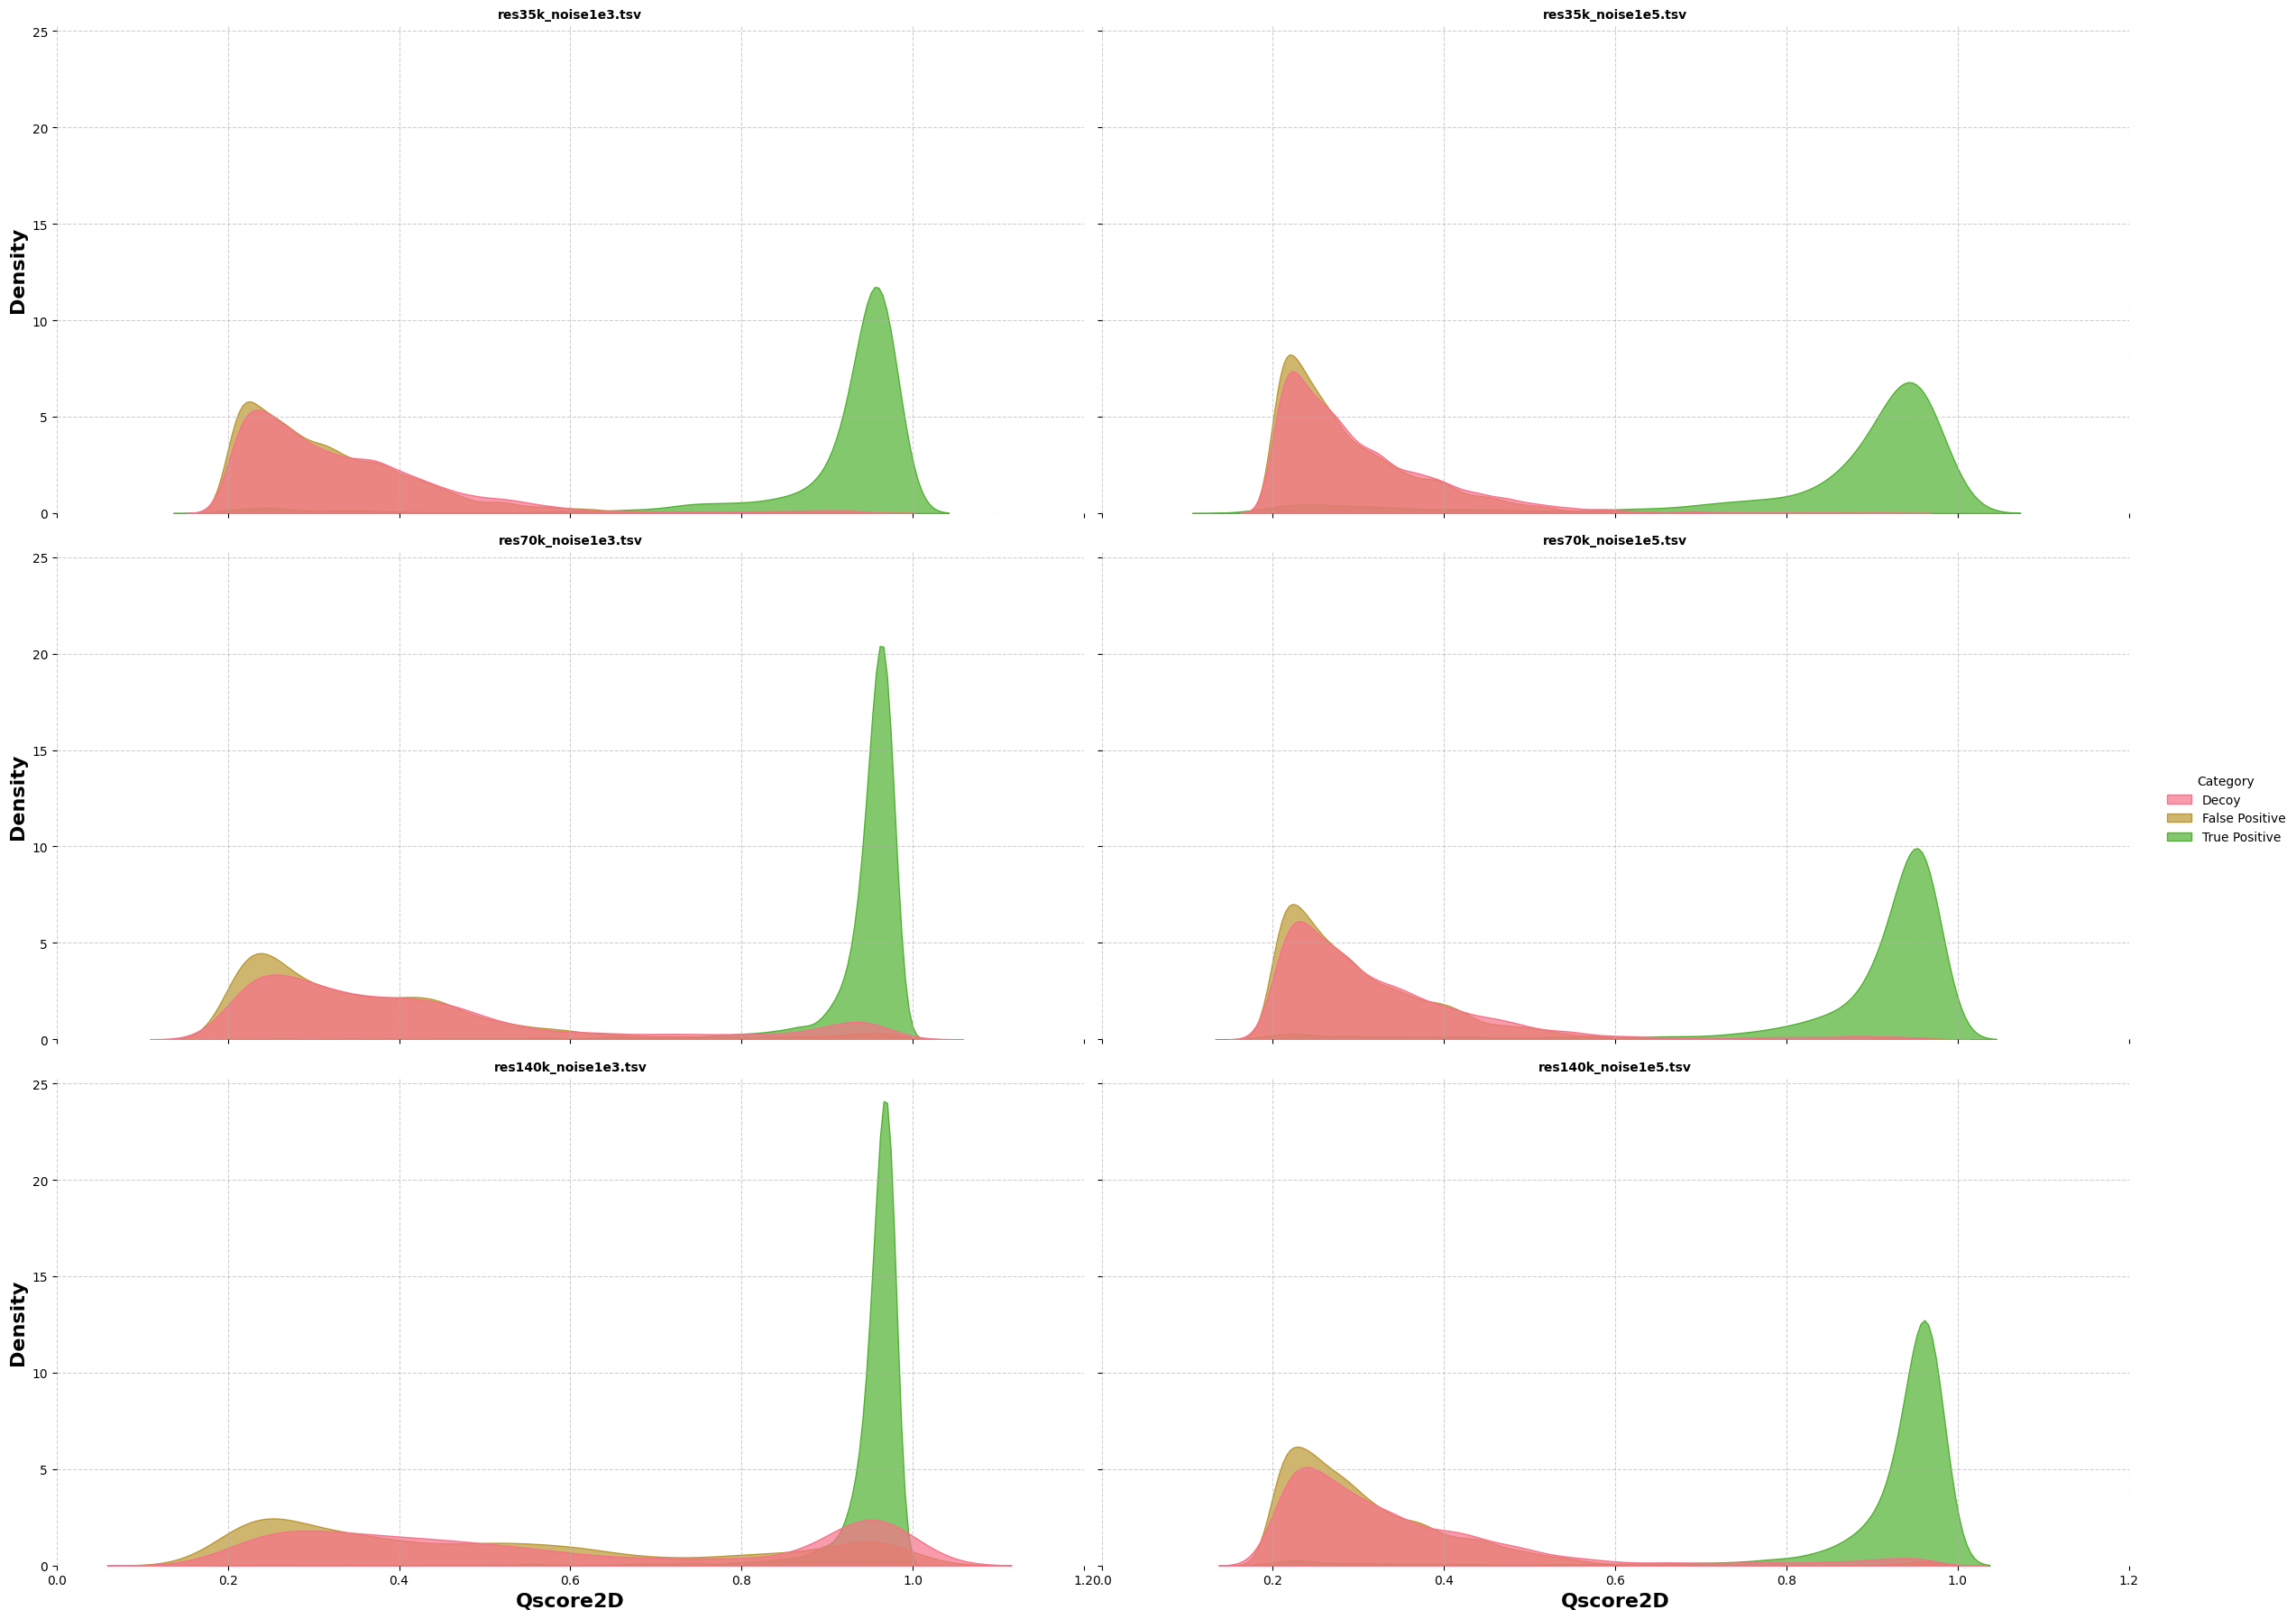

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of file paths to the six files you want to analyze
file_paths = [
    '/content/res35k_noise1e3.tsv',
    '/content/res35k_noise1e5.tsv',
    '/content/res70k_noise1e3.tsv',
    '/content/res70k_noise1e5.tsv',
    '/content/res140k_noise1e3.tsv',
    '/content/res140k_noise1e5.tsv'
]
original_path = '/content/chosen.csv'

# Load the original data
original_df = pd.read_csv(original_path)

# Define constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

def process_file(file_path):
    # Load the current combined file
    combined_df = pd.read_csv(file_path, sep='\t')

    # Process scan numbers
    fdval = combined_df[['ScanNum', 'MonoisotopicMass']].copy()
    fdval['ScanNum'] += 1  # Adjust for MATLAB indexing

    trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

    # Identify true positives
    tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) /
                      np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
    tpindex2 &= (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

    if iso > 0:
        for iso_shift in range(1, iso + 1):
            tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + iso_shift * protonmass - trueset[:, 1]) /
                                 np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + iso_shift * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
            tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - iso_shift * protonmass - trueset[:, 1]) /
                                 np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - iso_shift * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

    tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
    fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
    decoyindex = combined_df['TargetDecoyType'] > 0

    # Debugging: Print the sizes of the categories
    #print(f"File: {file_path}")
    #print(f"True Positives: {np.sum(tpindex)}")
    #print(f"False Positives: {np.sum(fpindex)}")
    #print(f"Decoy Masses: {np.sum(decoyindex)}")

    return combined_df, tpindex, fpindex, decoyindex

# Combine data from all files
all_data = []

for file_path in file_paths:
    combined_df, tpindex, fpindex, decoyindex = process_file(file_path)
    combined_df['Category'] = 'Unknown'
    combined_df.loc[tpindex, 'Category'] = 'True Positive'
    combined_df.loc[fpindex, 'Category'] = 'False Positive'
    combined_df.loc[decoyindex, 'Category'] = 'Decoy'
    combined_df['File'] = file_path.split('/')[-1]
    all_data.append(combined_df)

combined_all_df = pd.concat(all_data)

# Improved KDE Plotting
#palette = sns.color_palette("flare")  # Use a more distinct color palette
#sns.color_palette("Spectral", as_cmap=True)
palette = sns.color_palette("husl")



g = sns.displot(
    data=combined_all_df, x="Qscore2D", col="File", hue="Category",
    kind='kde', height=6, aspect=2, col_wrap=2, fill=True,
    facet_kws=dict(margin_titles=True), palette=palette,
    bw_adjust=0.7, alpha=0.7, common_norm=False, clip=(0, 1.2)  # Key changes
)

# Improve Titles & Labels
#g.fig.suptitle('KDE Plots of Qscore2D by File', fontsize=24, fontweight='bold')
g.set_axis_labels('Qscore2D', 'Density', fontsize=16, fontweight='bold')
g.set_titles(col_template="{col_name}", fontsize=20, fontweight='bold')

# Adjust x-axis limit and enhance grid visibility
for ax in g.axes.flatten():
    ax.set_xlim(0, 1.2)
    ax.grid(True, linestyle="--", alpha=0.6)  # Add grid for better readability
    sns.despine(left=True, bottom=True)  # Remove unnecessary borders

# Save high-resolution figure
plt.savefig("kde_plot_improved.png", dpi=300, bbox_inches="tight")

plt.show()



File: /content/mergedfile_res70k_noise1e3_ms1.tsv
True Positives: 1360
False Positives: 4287
Decoy Masses: 4114


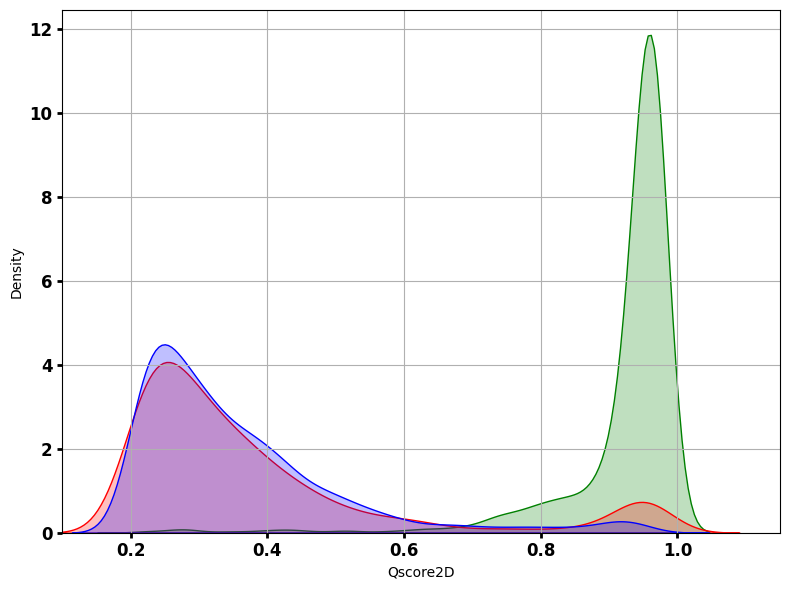

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path to the single file you want to analyze
file_path = '/content/mergedfile_res70k_noise1e3_ms1.tsv'
original_path = '/content/chosen.csv'

# Load the original data
original_df = pd.read_csv(original_path)

# Define constants
protonmass = 1.00727647
ppmtol = 10
iso = 0

# Load the current combined file
combined_df = pd.read_csv(file_path, sep='\t')

# Process scan numbers
fdval = combined_df[['ScanNum', 'MonoisotopicMass']].copy()
fdval['ScanNum'] += 1  # Adjust for MATLAB indexing

trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Identify true positives
tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) /
                  np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
tpindex2 &= (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

if iso > 0:
    for iso_shift in range(1, iso + 1):
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + iso_shift * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + iso_shift * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - iso_shift * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - iso_shift * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
decoyindex = combined_df['TargetDecoyType'] > 0

# Debugging: Print the sizes of the categories
print(f"File: {file_path}")
print(f"True Positives: {np.sum(tpindex)}")
print(f"False Positives: {np.sum(fpindex)}")
print(f"Decoy Masses: {np.sum(decoyindex)}")
# Plotting
plt.figure(figsize=(8, 6))
if np.sum(tpindex) > 0:
    sns.kdeplot(combined_df['Qscore2D'][tpindex], label='True Positives', fill=True, color='green')
if np.sum(fpindex) > 0:
    sns.kdeplot(combined_df['Qscore2D'][fpindex], label='False Positives', fill=True, color='red')
if np.sum(decoyindex) > 0:
    sns.kdeplot(combined_df['Qscore2D'][decoyindex], label='Decoy Masses', fill=True, color='blue')

plt.xlim([0.1, 1.15])
plt.grid(True)

# Make tick labels darker and bolder
plt.tick_params(axis='both', colors='black', labelsize=12, width=2)
plt.xticks(fontsize=12, fontweight='bold', color='black')
plt.yticks(fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.show()







In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# Full paths to the files (customize if paths are different)
files = [
    '/content/res35k_noise1e3_iso1.tsv',
    '/content/res35k_noise1e5_iso1.tsv',
    '/content/res70k_noise1e3_ms1_iso1.tsv',
    '/content/res70k_noise1e5_iso1.tsv',
    '/content/res140k_noise1e3_iso1.tsv',
    '/content/res140k_noise1e5_iso1.tsv'
]

ground_truth_file = '/content/chosen.csv'

# Load ground truth
original_df = pd.read_csv(ground_truth_file)
trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Store results for final summary
results = []

# Process each file
for filepath in files:
    if not os.path.exists(filepath):
        print(f"❌ File not found: {filepath}")
        continue

    case_name = os.path.basename(filepath).replace('mergedfile_', '').replace('_ms1.tsv', '')
    print(f"\n📂 Processing: {case_name}")

    combined_df = pd.read_csv(filepath, sep='\t')
    fdval = combined_df[['ScanNum', 'MonoisotopicMass']].copy()
    fdval['ScanNum'] += 1  # Adjust for MATLAB-style indexing

    tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) /
                      np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
    tpindex2 &= (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

    if iso > 0:
        for i in range(1, iso + 1):
            tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass - trueset[:, 1]) /
                                 np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
            tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass - trueset[:, 1]) /
                                 np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

    tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
    fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
    decoyindex = combined_df['TargetDecoyType'] > 0

    # --- Density Plot ---
    plt.figure(figsize=(8, 6))
    sns.kdeplot(combined_df['Qscore2D'][tpindex], label='True Positives', color='blue', fill=True)
    sns.kdeplot(combined_df['Qscore2D'][fpindex], label='False Positives', color='red', fill=True)
    sns.kdeplot(combined_df['Qscore2D'][decoyindex], label='Decoy Masses', color='green', fill=True)
    plt.title(f'Qscore2D Density - {case_name}')
    plt.xlabel('Qscore2D')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim([0.2, 1.0])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{case_name}_density_plot.png')
    plt.close()

    # --- FDR Plot ---
    plt.figure(figsize=(8, 6))
    fp_hist = np.histogram(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005))
    dp_hist = np.histogram(combined_df['Qscore2D'][~decoyindex], bins=np.arange(0, 1.005, 0.005))

    fpv, dpv = fp_hist[0], dp_hist[0]
    cdpv = np.cumsum(dpv[::-1])[::-1]
    cfpv = np.cumsum(fpv[::-1])[::-1]
    fdr = cfpv / (cdpv + np.finfo(float).eps)

    minfdr = 1
    for i in range(len(fdr)):
        fdr[i] = min(minfdr, fdr[i])
        minfdr = fdr[i]

    bin_centers = (dp_hist[1][1:] + dp_hist[1][:-1]) / 2
    plt.plot(bin_centers, fdr, 'darkblue', linewidth=1, label='True FDR')

    tmp = combined_df[['Qscore2D', 'Qvalue']][combined_df['TargetDecoyType'] == 0].sort_values('Qscore2D').values
    plt.plot(tmp[:, 0], tmp[:, 1], 'red', linestyle='--', linewidth=1, label='Estimated FDR')

    plt.title(f'FDR Plot - {case_name}')
    plt.xlabel('Qscore2D')
    plt.ylabel('q-value or FDR')
    plt.legend()
    plt.ylim([0, 1])
    plt.xlim([0.2, 1])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{case_name}_fdr_plot.png')
    plt.close()

    # --- FP/DM Ratio ---
    bins = np.arange(0, 1.05, 0.05)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    fp_hist = np.histogram(combined_df['Qscore2D'][fpindex], bins=bins)[0]
    dm_hist = np.histogram(combined_df['Qscore2D'][decoyindex], bins=bins)[0]

    ratios = []
    for i in range(len(fp_hist)):
        fp_count = fp_hist[i]
        dm_count = dm_hist[i]
        if fp_count + dm_count >= 10 and min(fp_count, dm_count) > 0:
            ratio = max(fp_count, dm_count) / min(fp_count, dm_count)
            ratios.append(ratio)

    if ratios:
        avg_ratio = np.mean(ratios)
        max_ratio = np.max(ratios)
    else:
        avg_ratio = np.nan
        max_ratio = np.nan

    results.append({
        'Case': case_name,
        'NumValidBins': len(ratios),
        'AvgFP/DMRatio': avg_ratio,
        'MaxFP/DMRatio': max_ratio
    })

# Save final summary
summary_df = pd.DataFrame(results)
summary_df.to_csv('fp_dm_ratios_summary.csv', index=False)
print("\n✅ Done! Summary saved to 'fp_dm_ratios_summary.csv'")



📂 Processing: res35k_noise1e3_iso1.tsv

📂 Processing: res35k_noise1e5_iso1.tsv

📂 Processing: res70k_noise1e3_ms1_iso1.tsv

📂 Processing: res70k_noise1e5_iso1.tsv

📂 Processing: res140k_noise1e3_iso1.tsv

📂 Processing: res140k_noise1e5_iso1.tsv

✅ Done! Summary saved to 'fp_dm_ratios_summary.csv'


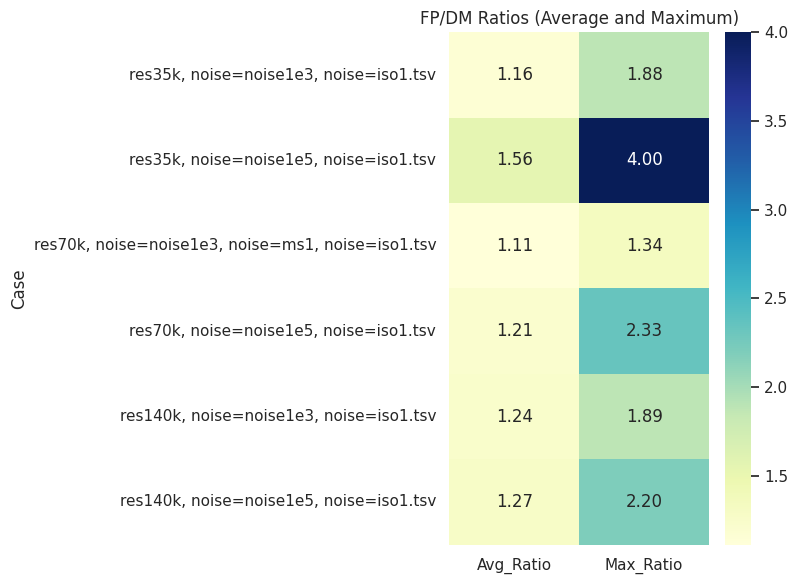

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("/content/fp_dm_ratios_summary.csv")

# Rename columns for clarity
df = df.rename(columns={
    "AvgFP/DMRatio": "Avg_Ratio",
    "MaxFP/DMRatio": "Max_Ratio"
})

# Clean up case names for better display
df["Case"] = df["Case"].str.replace("mergedfile_res", "", regex=False)
df["Case"] = df["Case"].str.replace("_", ", noise=", regex=False)
df["Case"] = df["Case"].str.replace("k", "k", regex=False)

# Prepare data for heatmap
heatmap_data = df.set_index("Case")[["Avg_Ratio", "Max_Ratio"]]

# Set the style
sns.set(style="whitegrid")

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("FP/DM Ratios (Average and Maximum)")
plt.ylabel("Case")
plt.tight_layout()

# Save the plot
plt.savefig("fp_dm_heatmap.png")
plt.show()


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# Full paths to the files (customize if paths are different)
files = [
    '/content/res35k_noise1e3_iso1.tsv',
    '/content/res35k_noise1e5_iso1.tsv',
    '/content/res70k_noise1e3_ms1_iso1.tsv',
    '/content/res70k_noise1e5_iso1.tsv',
    '/content/res140k_noise1e3_iso1.tsv',
    '/content/res140k_noise1e5_iso1.tsv'
]

ground_truth_file = '/content/chosen.csv'

# Load ground truth
original_df = pd.read_csv(ground_truth_file)
trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Store results for final summary
results = []

# Process each file
for filepath in files:
    if not os.path.exists(filepath):
        print(f"❌ File not found: {filepath}")
        continue

    case_name = os.path.basename(filepath).replace('mergedfile_', '').replace('_ms1.tsv', '')
    print(f"\n📂 Processing: {case_name}")

    combined_df = pd.read_csv(filepath, sep='\t')
    fdval = combined_df[['ScanNum', 'MonoisotopicMass']].copy()
    fdval['ScanNum'] += 1  # Adjust for MATLAB-style indexing

    tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) /
                      np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
    tpindex2 &= (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

    if iso > 0:
        for i in range(1, iso + 1):
            tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass - trueset[:, 1]) /
                                 np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
            tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass - trueset[:, 1]) /
                                 np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

    tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
    fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
    decoyindex = combined_df['TargetDecoyType'] > 0

    # --- Density Plot ---
    plt.figure(figsize=(8, 6))
    sns.kdeplot(combined_df['Qscore2D'][tpindex], label='True Positives', color='blue', fill=True)
    sns.kdeplot(combined_df['Qscore2D'][fpindex], label='False Positives', color='red', fill=True)
    sns.kdeplot(combined_df['Qscore2D'][decoyindex], label='Decoy Masses', color='green', fill=True)
    plt.title(f'Qscore2D Density - {case_name}')
    plt.xlabel('Qscore2D')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim([0.2, 1.0])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{case_name}_density_plot.png')
    plt.close()

    # --- FDR Plot ---
    plt.figure(figsize=(8, 6))
    fp_hist = np.histogram(combined_df['Qscore2D'][fpindex], bins=np.arange(0, 1.005, 0.005))
    dp_hist = np.histogram(combined_df['Qscore2D'][~decoyindex], bins=np.arange(0, 1.005, 0.005))

    fpv, dpv = fp_hist[0], dp_hist[0]
    cdpv = np.cumsum(dpv[::-1])[::-1]
    cfpv = np.cumsum(fpv[::-1])[::-1]
    fdr = cfpv / (cdpv + np.finfo(float).eps)

    minfdr = 1
    for i in range(len(fdr)):
        fdr[i] = min(minfdr, fdr[i])
        minfdr = fdr[i]

    bin_centers = (dp_hist[1][1:] + dp_hist[1][:-1]) / 2
    plt.plot(bin_centers, fdr, 'darkblue', linewidth=1, label='True FDR')

    tmp = combined_df[['Qscore2D', 'Qvalue']][combined_df['TargetDecoyType'] == 0].sort_values('Qscore2D').values
    plt.plot(tmp[:, 0], tmp[:, 1], 'red', linestyle='--', linewidth=1, label='Estimated FDR')

    plt.title(f'FDR Plot - {case_name}')
    plt.xlabel('Qscore2D')
    plt.ylabel('q-value or FDR')
    plt.legend()
    plt.ylim([0, 1])
    plt.xlim([0.2, 1.0])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{case_name}_fdr_plot.png')
    plt.close()

    # --- FP/DM Ratio ---
    qscore_filtered = combined_df[(combined_df['Qscore2D'] >= 0.2) & (combined_df['Qscore2D'] <= 1.0)]
    fpindex_filtered = fpindex & (combined_df['Qscore2D'] >= 0.2) & (combined_df['Qscore2D'] <= 1.0)
    decoyindex_filtered = decoyindex & (combined_df['Qscore2D'] >= 0.2) & (combined_df['Qscore2D'] <= 1.0)

    bins = np.arange(0.2, 1.05, 0.05)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    fp_hist = np.histogram(combined_df['Qscore2D'][fpindex_filtered], bins=bins)[0]
    dm_hist = np.histogram(combined_df['Qscore2D'][decoyindex_filtered], bins=bins)[0]

    ratios = []
    for i in range(len(fp_hist)):
        fp_count = fp_hist[i]
        dm_count = dm_hist[i]
        if fp_count + dm_count >= 10 and min(fp_count, dm_count) > 0:
            ratio = max(fp_count, dm_count) / min(fp_count, dm_count)
            ratios.append(ratio)

    if ratios:
        avg_ratio = np.mean(ratios)
        max_ratio = np.max(ratios)
    else:
        avg_ratio = np.nan
        max_ratio = np.nan

    results.append({
        'Case': case_name,
        'NumValidBins': len(ratios),
        'AvgFP/DMRatio': avg_ratio,
        'MaxFP/DMRatio': max_ratio
    })

# Save final summary
summary_df = pd.DataFrame(results)
summary_df.to_csv('fp_dm_ratios_summary.csv', index=False)
print("\n✅ Done! Summary saved to 'fp_dm_ratios_summary.csv'")



📂 Processing: res35k_noise1e3_iso1.tsv

📂 Processing: res35k_noise1e5_iso1.tsv

📂 Processing: res70k_noise1e3_ms1_iso1.tsv

📂 Processing: res70k_noise1e5_iso1.tsv

📂 Processing: res140k_noise1e3_iso1.tsv

📂 Processing: res140k_noise1e5_iso1.tsv

✅ Done! Summary saved to 'fp_dm_ratios_summary.csv'


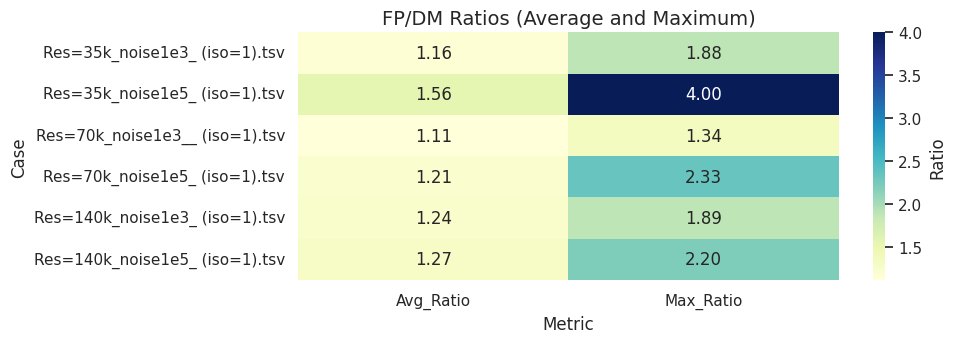

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("/content/fp_dm_ratios_summary.csv")

# Rename columns for clarity
df = df.rename(columns={
    "AvgFP/DMRatio": "Avg_Ratio",
    "MaxFP/DMRatio": "Max_Ratio"
})

# Clean up case names for display
df["Case"] = (
    df["Case"]
    .str.replace("res", "Res=", regex=False)
    .str.replace("_noise=", ", Noise=", regex=False)
    .str.replace("ms1", "", regex=False)
    .str.replace("iso1", " (iso=1)", regex=False)
    .str.strip(", ")
)

# Prepare data for heatmap
heatmap_data = df.set_index("Case")[["Avg_Ratio", "Max_Ratio"]]

# Set the style
sns.set(style="whitegrid")

# Create the heatmap
plt.figure(figsize=(10, len(df) * 0.6))  # Adaptive height
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={"label": "Ratio"})
plt.title("FP/DM Ratios (Average and Maximum)", fontsize=14)
plt.ylabel("Case")
plt.xlabel("Metric")
plt.xticks(rotation=0)
plt.tight_layout()

# Save and show
plt.savefig("fp_dm_heatmap.png", dpi=300)
plt.show()



📊 Valid bins: 15

🎯 Bins where FP/DM ratio == 4.0:
  Bin Center = 0.93, FP = 3, DM = 12


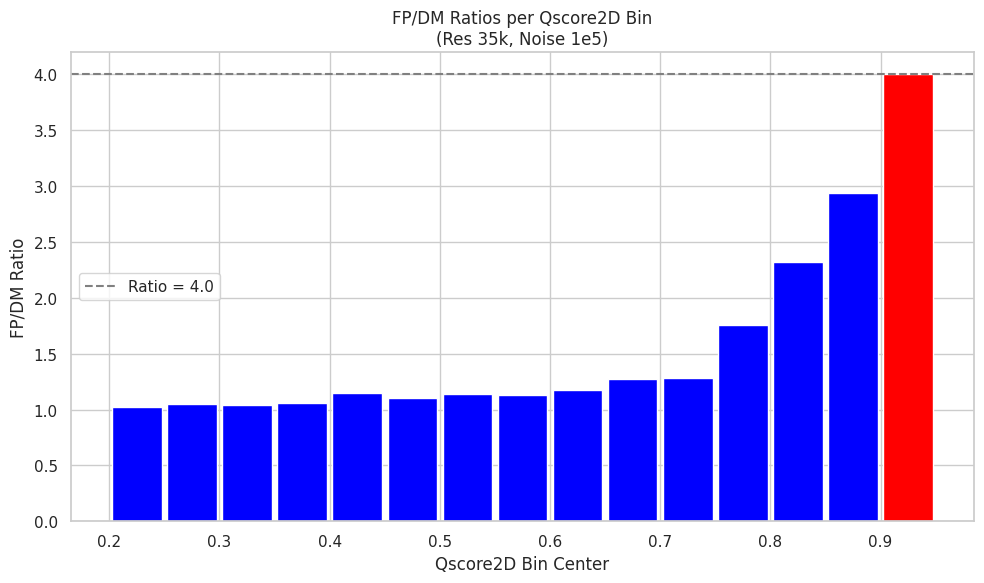

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
protonmass = 1.00727647
ppmtol = 10
iso = 1

# File paths
filepath = '/content/res35k_noise1e5_iso1.tsv'
ground_truth_file = '/content/chosen.csv'

# Load ground truth
original_df = pd.read_csv(ground_truth_file)
trueset = original_df[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Load data file
combined_df = pd.read_csv(filepath, sep='\t')
fdval = combined_df[['ScanNum', 'MonoisotopicMass']].copy()
fdval['ScanNum'] += 1

# Identify true positives
tpindex2 = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - trueset[:, 1]) /
                  np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0
tpindex2 &= (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - trueset[:, 0]) == 0, axis=1) > 0)

if iso > 0:
    for i in range(1, iso + 1):
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] + i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)
        tpindex2 |= (np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass - trueset[:, 1]) /
                             np.maximum(fdval.iloc[:, 1].values[:, np.newaxis] - i * protonmass, trueset[:, 1]) * 1e6 < ppmtol, axis=1) > 0)

tpindex = tpindex2 & (combined_df['TargetDecoyType'] == 0)
fpindex = (~tpindex2) & (combined_df['TargetDecoyType'] == 0)
decoyindex = combined_df['TargetDecoyType'] > 0

# Bin setup
bins = np.arange(0, 1.05, 0.05)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Histograms
fp_hist = np.histogram(combined_df['Qscore2D'][fpindex], bins=bins)[0]
dm_hist = np.histogram(combined_df['Qscore2D'][decoyindex], bins=bins)[0]

# Analyze ratios
ratios = []
highlighted_bins = []
for i in range(len(fp_hist)):
    fp_count = fp_hist[i]
    dm_count = dm_hist[i]
    if fp_count + dm_count >= 10 and min(fp_count, dm_count) > 0:
        ratio = max(fp_count, dm_count) / min(fp_count, dm_count)
        ratios.append((bin_centers[i], ratio, fp_count, dm_count))
        if ratio == 4.0:
            highlighted_bins.append((bin_centers[i], fp_count, dm_count))

# Output
print(f"\n📊 Valid bins: {len(ratios)}")
if highlighted_bins:
    print("\n🎯 Bins where FP/DM ratio == 4.0:")
    for center, fp, dm in highlighted_bins:
        print(f"  Bin Center = {center:.2f}, FP = {fp}, DM = {dm}")
else:
    print("\n❌ No bins with FP/DM ratio == 4.0 found.")

# Plot bar chart of all ratios
if ratios:
    x_vals = [r[0] for r in ratios]
    y_vals = [r[1] for r in ratios]
    colors = ['red' if y == 4.0 else 'blue' for y in y_vals]

    plt.figure(figsize=(10, 6))
    plt.bar(x_vals, y_vals, width=0.045, color=colors)
    plt.axhline(4.0, color='gray', linestyle='--', label='Ratio = 4.0')
    plt.title("FP/DM Ratios per Qscore2D Bin\n(Res 35k, Noise 1e5)")
    plt.xlabel("Qscore2D Bin Center")
    plt.ylabel("FP/DM Ratio")
    plt.legend()
    plt.tight_layout()
    plt.savefig("fp_dm_ratios_res35k_noise1e5.png")
    plt.show()


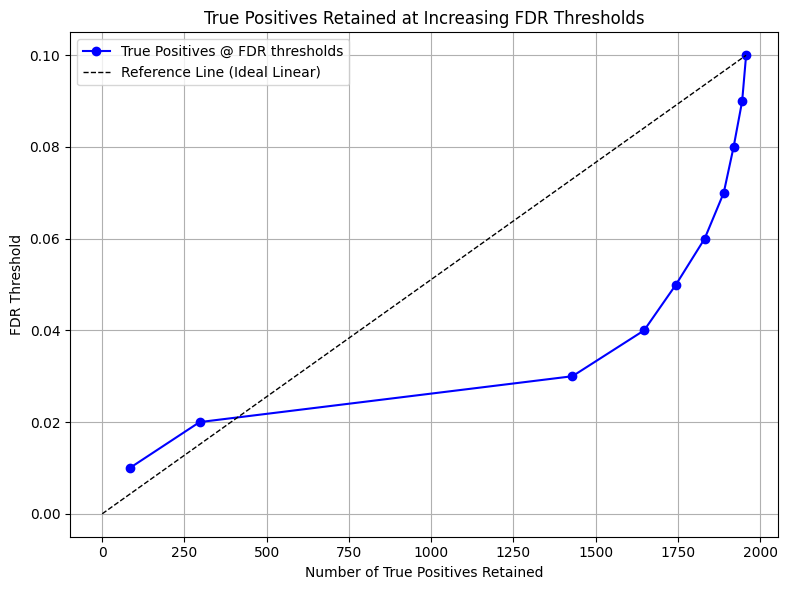

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load deconvolved result
df = pd.read_csv('/content/res70k_noise1e3_ms1_iso1.tsv', sep='\t')

# Load ground truth
gt = pd.read_csv('/content/chosen.csv')
gt_array = gt[['ScanNum', 'MonoisotopicMass']].to_numpy()
protonmass = 1.00727647
ppmtol = 10
iso = 1  # Set to 0 for this analysis (no isotope error allowed)

# Compute true positives
fdval = df[['ScanNum', 'MonoisotopicMass']].copy()
fdval['ScanNum'] += 1  # Adjust indexing

# Match logic
tpindex = np.sum(np.abs(fdval.iloc[:, 1].values[:, np.newaxis] - gt_array[:, 1]) /
                 np.maximum(fdval.iloc[:, 1].values[:, np.newaxis], gt_array[:, 1]) * 1e6 < ppmtol, axis=1) > 0
tpindex &= (np.sum(np.abs(fdval.iloc[:, 0].values[:, np.newaxis] - gt_array[:, 0]) == 0, axis=1) > 0)
tpindex &= (df['TargetDecoyType'] == 0)  # Only target hits

# Add TP info to dataframe
df['isTP'] = tpindex

# --- FDR Threshold vs TP Count ---
thresholds = np.arange(0.01, 0.101, 0.01)
tp_counts = []

for thresh in thresholds:
    filtered = df[(df['Qvalue'] <= thresh) & (df['TargetDecoyType'] == 0)]
    tp_count = np.sum(filtered['isTP'])
    tp_counts.append(tp_count)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(tp_counts, thresholds, marker='o', label='True Positives @ FDR thresholds', color='blue')
plt.plot([0, max(tp_counts)], [0, max(thresholds)], 'k--', label='Reference Line (Ideal Linear)', linewidth=1)

plt.xlabel("Number of True Positives Retained")
plt.ylabel("FDR Threshold")
plt.title("True Positives Retained at Increasing FDR Thresholds")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("tp_vs_fdr_threshold.png")
plt.show()


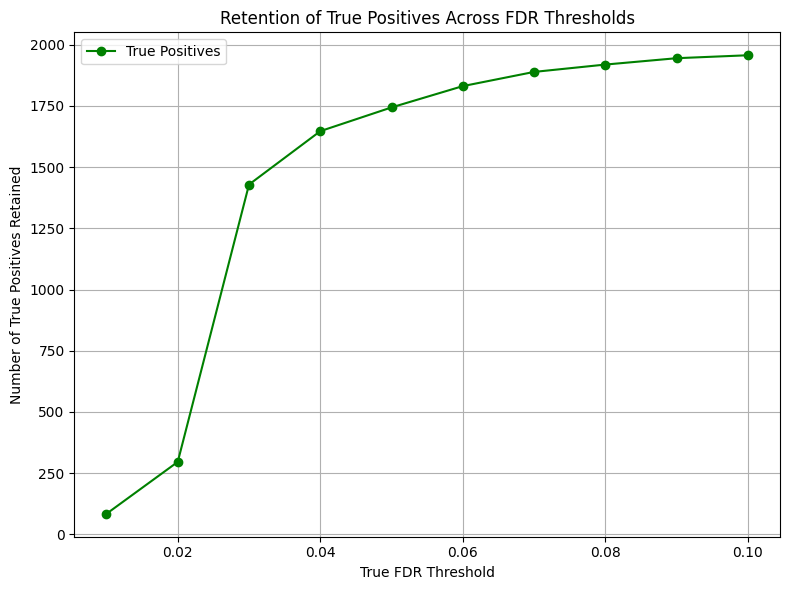

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load deconvolution results
df = pd.read_csv('/content/res70k_noise1e3_ms1_iso1.tsv', sep='\t')

# Load ground truth (true proteoforms)
gt = pd.read_csv('/content/chosen.csv')
gt_array = gt[['ScanNum', 'MonoisotopicMass']].to_numpy()

# Parameters
protonmass = 1.00727647
ppmtol = 10
iso = 1  # isotope error = 0

# Match ground truth (TP identification)
fdval = df[['ScanNum', 'MonoisotopicMass']].copy()
fdval['ScanNum'] += 1  # Align indexing

# Identify true positives
tpindex = (np.abs(fdval['MonoisotopicMass'].values[:, None] - gt_array[:, 1]) /
           np.maximum(fdval['MonoisotopicMass'].values[:, None], gt_array[:, 1]) * 1e6 < ppmtol).any(axis=1)
tpindex &= (np.abs(fdval['ScanNum'].values[:, None] - gt_array[:, 0]) == 0).any(axis=1)
tpindex &= (df['TargetDecoyType'] == 0)

df['isTP'] = tpindex

# Loop over FDR thresholds and count true positives retained
fdr_thresholds = np.arange(0.01, 0.101, 0.01)
tp_counts = []

for fdr in fdr_thresholds:
    filtered = df[(df['Qvalue'] <= fdr) & (df['TargetDecoyType'] == 0)]
    tp_count = filtered['isTP'].sum()
    tp_counts.append(tp_count)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fdr_thresholds, tp_counts, marker='o', color='green', label='True Positives')
#plt.plot(fdr_thresholds, np.max(tp_counts) * fdr_thresholds / np.max(fdr_thresholds), 'k--', label='Reference Line (linear growth)')

plt.xlabel("True FDR Threshold")
plt.ylabel("Number of True Positives Retained")
plt.title("Retention of True Positives Across FDR Thresholds")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("truepositives_vs_fdr.png")
plt.show()


Total number of noise decoys: 3954

Noise decoy count per scan:
ScanNum
0     47
1     42
2     39
3     40
4     53
      ..
95    46
96    70
97    60
98    69
99    54
Name: count, Length: 100, dtype: int64


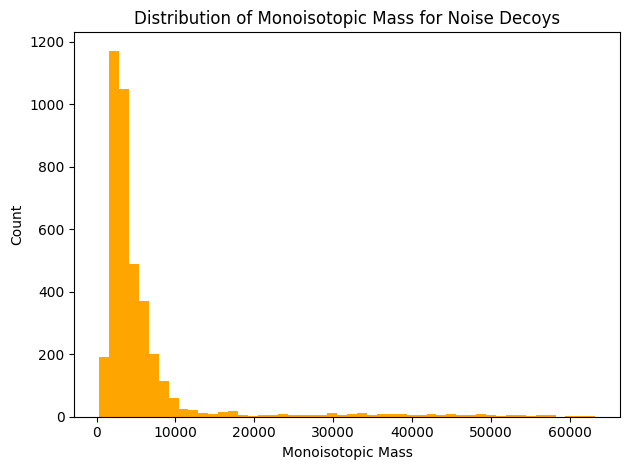

In [13]:
import pandas as pd

# Load your TSV file
file_path = '/content/mergedfile_res70k_noise1e3_ms1_iso0.tsv'  # <- Update this path
df = pd.read_csv(file_path, sep='\t')

# Filter only noise decoys (TargetDecoyType == 1)
noise_decoys = df[df['TargetDecoyType'] == 1]

# Count total number of noise decoys
total_noise_decoys = len(noise_decoys)
print(f"Total number of noise decoys: {total_noise_decoys}")

# Optional: Count how many noise decoys per scan number
if 'ScanNum' in df.columns:
    scan_dist = noise_decoys['ScanNum'].value_counts().sort_index()
    print("\nNoise decoy count per scan:")
    print(scan_dist)

# Optional: Distribution by MonoisotopicMass if you're interested
if 'MonoisotopicMass' in df.columns:
    import matplotlib.pyplot as plt
    plt.hist(noise_decoys['MonoisotopicMass'], bins=50, color='orange')
    plt.title("Distribution of Monoisotopic Mass for Noise Decoys")
    plt.xlabel("Monoisotopic Mass")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [1]:
pip install pyopenms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 8.0 MB/s eta 0:00:00


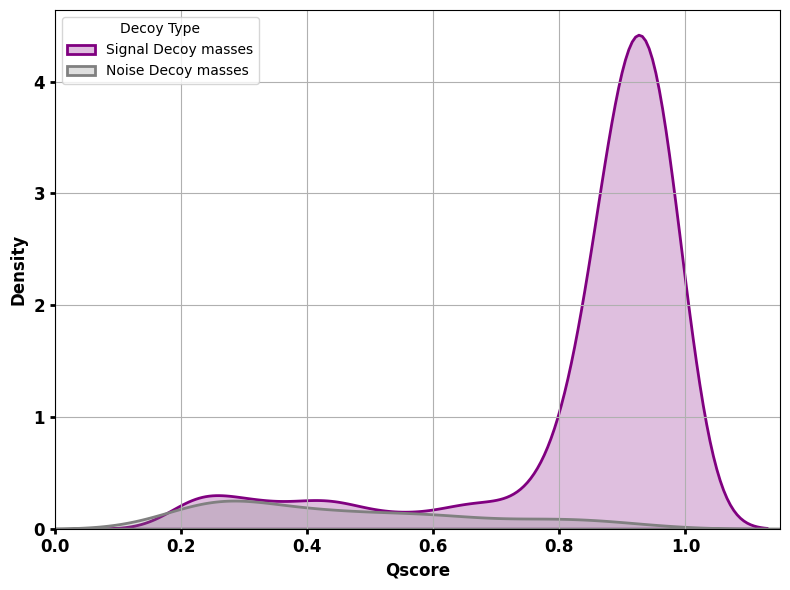

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the TSV file
file_path = '/content/Res70k,noise0,centroid-2,centroid_ms1.tsv'
df = pd.read_csv(file_path, sep='\t')

# Filter for decoys only
decoy_df = df[df['TargetDecoyType'].isin([1, 2])]

# Plot density distribution of Qscore2D for each decoy type
plt.figure(figsize=(8, 6))
sns.kdeplot(data=decoy_df, x='Qscore', hue='TargetDecoyType', fill=True,
            palette={1: 'grey', 2: 'purple'}, linewidth=2)

#plt.title('Density Distribution of Decoy Types by Q-score', fontsize=14, fontweight='bold')
plt.xlabel('Qscore', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.xlim([0, 1.15])
plt.grid(True)
plt.legend(title='Decoy Type', labels=['Signal Decoy masses', 'Noise Decoy masses'])

# Enhance tick labels
plt.tick_params(axis='both', colors='black', labelsize=12, width=2)
plt.xticks(fontsize=12, fontweight='bold', color='black')
plt.yticks(fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.show()
